# Diagnosi di Polmonite

Lo scopo di questo progetto è sviluppare un sistema automatizzato per la diagnosi automatica della polmonite a partire da radiografie toraciche.  


In una prima fase, vengono utilizzati classificatori basati su Random Forest, che ci forniranno una baseline per le successive valutazioni.
Nella fase successiva, il progetto si concentra sull'utilizzo di Reti Neurali Convoluzionali (CNN), che rappresentano lo standard per l'elaborazione di immagini.


Un elemento distintivo è l'integrazione di un meccanismo di bilanciamento dinamico tra falsi positivi (FP) e falsi negativi (FN). Questo strumento consente agli utenti di adattare il comportamento del modello in base alle loro preferenze specifiche, ad esempio privilegiando la riduzione dei falsi negativi (maggiore recall) in contesti medici critici, senza dover riaddestrare il modello.

## Operazioni preliminari

### Setup e Importazioni
Prima di iniziare, configuriamo l'ambiente e importiamo le librerie necessarie per il progetto

In [1]:
from google.colab import drive
import os
import joblib
import zipfile
import sys
import inspect
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D, Input, LayerNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import Model as TFModel
from tensorflow.keras.regularizers import L2, L1, L1L2
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.models import save_model, load_model
from keras import Model as KerasModel
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, ConfusionMatrixDisplay, recall_score, precision_recall_curve
import matplotlib.pyplot as plt
from collections import Counter

# Configurazione seed per riproducibilità
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

drive.mount('/content/drive')

Mounted at /content/drive


Se i pesi sono stati salvati in memoria, li carichiamo per evitare di riaddestrare i modelli.

In [2]:
WEIGHT_DIR = "/content/drive/MyDrive/ML/ML_Weight/"
model_metrics_dict = {}
saveData = True

def save_all_models(save_dir=WEIGHT_DIR):
    if saveData == False:
      return
    os.makedirs(save_dir, exist_ok=True)
    keras_count, sklearn_count = 0, 0
    for var_name, var_value in globals().items():
        try:
            if hasattr(var_value, "save") and callable(getattr(var_value, "save")):
                model_path = os.path.join(save_dir, f"{var_name}.keras")
                save_model(var_value, model_path)
                keras_count += 1
            elif isinstance(var_value, BaseEstimator):
                model_path = os.path.join(save_dir, f"{var_name}_sklearn.pkl")
                joblib.dump(var_value, model_path)
                sklearn_count += 1
        except Exception as e:
            print("")
    total_size = sum(os.path.getsize(os.path.join(save_dir, f)) for f in os.listdir(save_dir))

def restore_all_models(save_dir=WEIGHT_DIR):
    restored_vars = {}
    for item in os.listdir(save_dir):
        try:
            if item.endswith(".keras"):
                model_name = item.replace(".keras", "")
                model_path = os.path.join(save_dir, item)
                restored_vars[model_name] = load_model(model_path)
                print(f"Modello Keras '{model_name}' caricato da: {model_path}")
            elif item.endswith("_sklearn.pkl"):
                model_name = item.replace("_sklearn.pkl", "")
                model_path = os.path.join(save_dir, item)
                restored_vars[model_name] = joblib.load(model_path)
                print(f"Modello Scikit-learn '{model_name}' caricato da: {model_path}")
        except Exception as e:
            print("")
    globals().update(restored_vars)

if not os.path.exists(WEIGHT_DIR) or len(os.listdir(WEIGHT_DIR)) == 0:
    user_input = input("La directory per salvare i modelli non esiste o non ci sono modelli salvati all'interno. Vuoi abilitare il salvataggio dei modelli? (s/n): ")
    if user_input.lower() == 's':
        os.makedirs(WEIGHT_DIR, exist_ok=True)
    else:
        saveData = False
        print("Salvataggio dei modelli annullato.")
else:
    restore_all_models()

Modello Scikit-learn '_' caricato da: /content/drive/MyDrive/ML/ML_Weight/__sklearn.pkl
Modello Keras 'cnn_simple_h' caricato da: /content/drive/MyDrive/ML/ML_Weight/cnn_simple_h.keras
Modello Scikit-learn 'randomFC_m' caricato da: /content/drive/MyDrive/ML/ML_Weight/randomFC_m_sklearn.pkl
Modello Keras 'cnn_complex_h' caricato da: /content/drive/MyDrive/ML/ML_Weight/cnn_complex_h.keras
Modello Keras 'cnn_simple_m' caricato da: /content/drive/MyDrive/ML/ML_Weight/cnn_simple_m.keras
Modello Scikit-learn 'randomFC_h' caricato da: /content/drive/MyDrive/ML/ML_Weight/randomFC_h_sklearn.pkl
Modello Keras 'cnn_complex_l' caricato da: /content/drive/MyDrive/ML/ML_Weight/cnn_complex_l.keras
Modello Scikit-learn '_21' caricato da: /content/drive/MyDrive/ML/ML_Weight/_21_sklearn.pkl
Modello Scikit-learn 'randomFC_l' caricato da: /content/drive/MyDrive/ML/ML_Weight/randomFC_l_sklearn.pkl
Modello Keras 'cnn_complex_m' caricato da: /content/drive/MyDrive/ML/ML_Weight/cnn_complex_m.keras
Modello Ker

### Definizione delle utility
Definiamo alcune funzioni utili come la normalizzazione delle immagini ed una funzione per la visualizzazione della confusion matrix

In [3]:
def check_dataset(dataset):
    for images, labels in dataset:
        if images is None or labels is None:
            print("Errore: Trovato un elemento nullo nel dataset.")
            return False
        if len(labels) != len(images):
            print("Errore: Il numero di immagini non corrisponde al numero di etichette.")
            return False
    print("Il dataset è valido.\n")
    return True

def preprocess_data(ds):
    images = []
    labels = []
    for image_batch, label_batch in ds:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images, labels

def check_class_balance(dataset):
  class_counts = Counter()
  for _, labels in dataset:
      class_counts.update(labels.numpy().tolist())
  for class_id, count in class_counts.items():
      print(f"Classe {class_names[class_id]}: {count} esempi")

def normalize(dataset):
    def normalize_image(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        return image, label
    normalized_dataset = dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
    return normalized_dataset

def graphics(y_test, y_pred, history=None):
    save_all_models()
    plt.figure(figsize=(12, 4))
    if history!=None:
      plt.subplot(1, 2, 1)
      plt.plot(history.history['loss'], label='Training Loss')
      plt.plot(history.history['val_loss'], label='Validation Loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()

    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()


def resize_images(images, new_size):
    return np.array([tf.image.resize(image, new_size).numpy() for image in images])

def convert_to_grayscale(images, labels):
    images = tf.image.rgb_to_grayscale(images)
    return images, labels

In [4]:
def plot_f1_scores(model_metrics_dict, augmented=True, validation=False, rf=True, onlyAug=False):
    model_names = []
    f1_scores = []

    for model_name, metrics in model_metrics_dict.items():
        # Escludi i modelli con nomi contenenti "dh_", "dm_" o "dl_"
        if any(prefix in model_name for prefix in ["dh_", "dm_", "dl_"]) and augmented == False:
            continue
        if not any(prefix in model_name for prefix in ["dh_", "dm_", "dl_"]) and onlyAug == True:
            continue


        if isinstance(metrics, dict):
            # Caso Random Forest (RF)
            if "default" in metrics and "optimal" in metrics and rf == True:
                model_names.append(f"{model_name}")
                f1_scores.append(metrics["optimal"]["f1_score"])

            # Caso CNN
            elif "valid_f1" in metrics and "test_f1" in metrics:
                if validation:
                    model_names.append(f"{model_name} (Valid)")
                    f1_scores.append(metrics["valid_f1"])
                model_names.append(f"{model_name}")
                f1_scores.append(metrics["test_f1"])

    # Creazione del grafico
    plt.figure(figsize=(14, 10))
    bars = plt.barh(model_names, f1_scores, color='skyblue', alpha=0.85)
    plt.xlabel("F1-score", fontsize=12)
    plt.ylabel("Modelli", fontsize=12)
    plt.title("Confronto F1-score", fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle="--", alpha=0.6)

    # Aggiunta dei valori sui lati delle barre
    for bar, score in zip(bars, f1_scores):
        plt.text(
            bar.get_width() + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{score:.3f}",
            va="center",
            fontsize=10,
            color="black"
        )

    plt.tight_layout()
    plt.show()

### Preparazione del Dataset
Carichiamo il dataset mantenendo una risoluzione elevata e prepariamo i dati per l'addestramento.

In [5]:
DATASET_ZIP = "/content/drive/MyDrive/ML/chest_xray.zip"
DATASET_EXTRACT_DIR = "/tmp"
DATASET_DIR = os.path.join(DATASET_EXTRACT_DIR, "chest_xray")
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR = os.path.join(DATASET_DIR, "test")
LOW_IMAGE_SIZE = (32, 32)
MEDIUM_IMAGE_SIZE = (48, 48)
HIGH_IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32

if not os.path.exists(DATASET_DIR) or len(os.listdir(DATASET_DIR)) == 0:
    print("Dataset non trovato nella directory. Estrazione in corso...")
    os.makedirs(DATASET_EXTRACT_DIR, exist_ok=True)
    with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
        zip_ref.extractall(DATASET_EXTRACT_DIR)
    print(f"Dataset estratto in: {DATASET_DIR}")
else:
    print("Dataset già presente. Nessuna estrazione necessaria.")

Dataset non trovato nella directory. Estrazione in corso...
Dataset estratto in: /tmp/chest_xray


In [6]:
# Caricamento completo del dataset
full_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    batch_size=BATCH_SIZE,
    image_size=HIGH_IMAGE_SIZE,
)

# Caricamento del dataset di test
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    batch_size=BATCH_SIZE,
    image_size=HIGH_IMAGE_SIZE,
)

Found 5232 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [7]:
class_names = full_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


### Verifica immagini presenti nel dataset

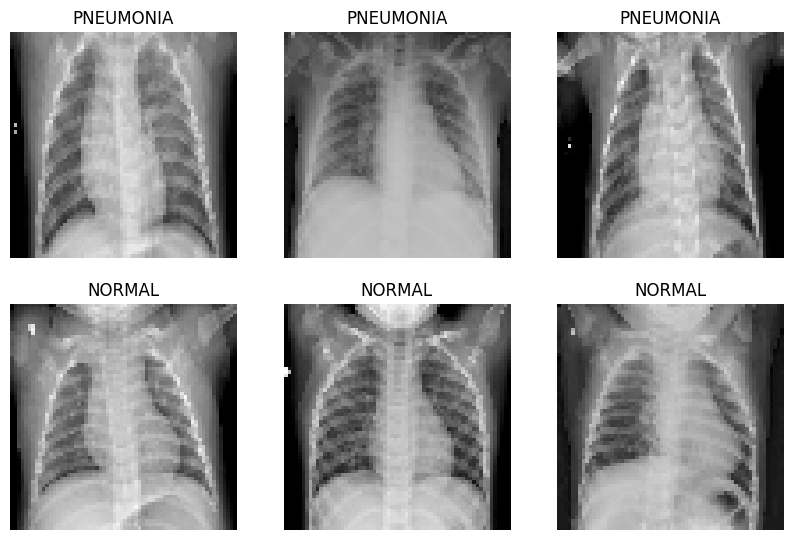

In [8]:
# Imposta la dimensione della figura
plt.figure(figsize=(10, 10))

# Prendi un batch di immagini e label dal dataset completo
for images, labels in full_ds.take(1):
    for i in range(min(6, len(images))):  # Mostra fino a 9 immagini
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Mostra l'immagine
        plt.title(class_names[labels[i].numpy()])  # Mostra il nome della classe
        plt.axis("off")  # Nascondi gli assi

# Mostra la figura
plt.show()

Dato che sono in bianco e nero verifichiamo la dimensione e cerchiamo di capire come sono rappresentate

In [9]:
for images, labels in full_ds.take(1):
    print(f"Forma delle immagini: {images.shape}")
    break

for images, labels in full_ds.take(1):
    is_grayscale = np.all(images[..., 0] == images[..., 1]) and np.all(images[..., 1] == images[..., 2])
    print(f"Le immagini sono in scala di grigi replicate su 3 canali: {is_grayscale}")
    break

Forma delle immagini: (32, 64, 64, 3)
Le immagini sono in scala di grigi replicate su 3 canali: True


### Reshape

Andiamo ad eliminare due dimensioni dato che contengono informazioni ridondanti e manteniamo un solo canale

In [10]:
# Converti il dataset in scala di grigi
full_ds_grayscale = full_ds.map(convert_to_grayscale)
test_ds_grayscale = test_ds.map(convert_to_grayscale)

# Verifica la nuova forma
for images, labels in full_ds_grayscale.take(1):
    print(f"Forma delle immagini in scala di grigi: {images.shape}")
    break

Forma delle immagini in scala di grigi: (32, 64, 64, 1)


### Verifica integrità dei dati

Verifichiamo che non ci siano elementi nulli nel dataset e che tutte le immagini abbiano una label.

In [11]:
print("Verifica sul training set:")
assert check_dataset(full_ds_grayscale) is True

print("Verifica sul test set:")
assert check_dataset(test_ds_grayscale) is True

Verifica sul training set:
Il dataset è valido.

Verifica sul test set:
Il dataset è valido.



### Composizione del Dataset
Il 74% delle immagini rappresentano soggetti affetti da polmonite.  
Il 26% soggetti sani.  
Il dataset è sbilanciato

In [12]:
check_class_balance(full_ds_grayscale)

Classe PNEUMONIA: 3883 esempi
Classe NORMAL: 1349 esempi


### Normalizziamo
Scaliamo il valore dei pixel tra 0 ed 1

In [13]:
full_ds_normalized = normalize(full_ds_grayscale)
test_ds_normalized = normalize(test_ds_grayscale)

### Training Validation Testing
Procediamo dividendo i dataset tra training e validation.  

In [14]:
images = []
labels = []

for image_batch, label_batch in full_ds_normalized:
    images.append(image_batch)
    labels.append(label_batch)

# Unisce tutte le immagini e le etichette in un unico array
images = tf.concat(images, axis=0)
labels = tf.concat(labels, axis=0)

# Convertiamo i tensori in numpy arrays
images_numpy = images.numpy()
labels_numpy = labels.numpy()

Le immagini possono essere di tre tipologie:

*   Alta definizione: 64x64
*   Media definizione: 48x48
*   Bassa definizione: 32x32
  
Avremo vari dataset in basa alla dimensione delle immagini

In [15]:
# Suddivisione del dataset in training e validation
X_train_h, X_valid_h, y_train, y_valid = train_test_split(images_numpy, labels_numpy, test_size=0.2, random_state=123)
X_full_train_h, y_full_train = preprocess_data(full_ds_normalized)
X_test_h, y_test = preprocess_data(test_ds_normalized)

X_train_m = resize_images(X_train_h, MEDIUM_IMAGE_SIZE)
X_valid_m = resize_images(X_valid_h, MEDIUM_IMAGE_SIZE)
X_full_train_m = resize_images(X_full_train_h, MEDIUM_IMAGE_SIZE)
X_test_m = resize_images(X_test_h, MEDIUM_IMAGE_SIZE)

X_train_l = resize_images(X_train_h, LOW_IMAGE_SIZE)
X_valid_l = resize_images(X_valid_h, LOW_IMAGE_SIZE)
X_full_train_l = resize_images(X_full_train_h, LOW_IMAGE_SIZE)
X_test_l = resize_images(X_test_h, LOW_IMAGE_SIZE)

Verifichiamo che le nuove dimensioni siano corrette

In [16]:
print("High shape:",X_train_h.shape)
print("Medium shape:",X_train_m.shape)
print("Low shape:",X_train_l.shape)

High shape: (4185, 64, 64, 1)
Medium shape: (4185, 48, 48, 1)
Low shape: (4185, 32, 32, 1)


## Random Forest
Il primo modello che viene analizzato è Random Forest che viene spesso utilizzato con buoni risultati in task di classificazione. Si sceglie pertanto di partire con RF per fornire una baseline, lo si userà come lower bound.

In [17]:
# Reshape delle immagini dato che RF non può lavorare con dati di input che possiedono una rappresentazione a griglia/tensore
X_train_h_flatten = X_full_train_h.reshape(len(X_full_train_h), -1)
X_test_h_flatten = X_test_h.reshape(len(X_test_h), -1)

X_train_m_flatten = X_full_train_m.reshape(len(X_full_train_m), -1)
X_test_m_flatten = X_test_m.reshape(len(X_test_m), -1)

X_train_l_flatten = X_full_train_l.reshape(len(X_full_train_l), -1)
X_test_l_flatten = X_test_l.reshape(len(X_test_l), -1)

In [18]:
randomFC_h = RandomForestClassifier(n_estimators=100, random_state=42)
randomFC_m = RandomForestClassifier(n_estimators=100, random_state=42)
randomFC_l = RandomForestClassifier(n_estimators=100, random_state=42)

Si è scelto di utilizzare cross validation per identificare la soglia che massimizzi l'f1 score

In [19]:
def optimize_threshold_with_cv(model, X, y, n_split=5, random_state=42):
    cv = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=random_state)
    optimal_thresholds = []
    cv_f1_scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), start=1):
        print(f"Fold {fold}/{n_split} in corso...")

        # Suddivisione dei dati
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]

        # Addestramento del modello
        model.fit(X_fold_train, y_fold_train)
        y_val_proba = model.predict_proba(X_fold_val)[:, 1]

        # Calcolo della soglia ottimale basata sull'F1-score
        precisions, recalls, thresholds = precision_recall_curve(y_fold_val, y_val_proba)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

        # Sostituisce eventuali NaN con 0
        f1_scores = np.nan_to_num(f1_scores)
        best_threshold = thresholds[f1_scores.argmax()]

        # Salva la soglia e l'F1-score migliore
        optimal_thresholds.append(best_threshold)
        cv_f1_scores.append(f1_scores.max())

    # Calcola le medie
    final_threshold = np.mean(optimal_thresholds)
    mean_f1 = np.mean(cv_f1_scores)
    std_f1 = np.std(cv_f1_scores)

    # Output finale
    print(f"Soglie ottenute: {optimal_thresholds}")
    print(f"Soglia ottimale media: {final_threshold:.2f}")
    print(f"F1-score medio: {mean_f1:.2f} (+/- {std_f1:.2f})\n")

    return final_threshold

In [20]:
final_threshold_h = optimize_threshold_with_cv(model=randomFC_h, X=X_train_h_flatten, y=y_full_train, n_split=5, random_state=42)
final_threshold_m = optimize_threshold_with_cv(model=randomFC_m, X=X_train_m_flatten, y=y_full_train, n_split=5, random_state=42)
final_threshold_l = optimize_threshold_with_cv(model=randomFC_l, X=X_train_l_flatten, y=y_full_train, n_split=5, random_state=42)

Fold 1/5 in corso...
Fold 2/5 in corso...
Fold 3/5 in corso...
Fold 4/5 in corso...
Fold 5/5 in corso...
Soglie ottenute: [0.59, 0.48, 0.57, 0.62, 0.53]
Soglia ottimale media: 0.56
F1-score medio: 0.97 (+/- 0.00)

Fold 1/5 in corso...
Fold 2/5 in corso...
Fold 3/5 in corso...
Fold 4/5 in corso...
Fold 5/5 in corso...
Soglie ottenute: [0.55, 0.46, 0.52, 0.58, 0.52]
Soglia ottimale media: 0.53
F1-score medio: 0.97 (+/- 0.00)

Fold 1/5 in corso...
Fold 2/5 in corso...
Fold 3/5 in corso...
Fold 4/5 in corso...
Fold 5/5 in corso...
Soglie ottenute: [0.55, 0.52, 0.57, 0.56, 0.51]
Soglia ottimale media: 0.54
F1-score medio: 0.97 (+/- 0.00)



In [21]:
randomFC_h.fit(X_train_h_flatten, y_full_train)
randomFC_m.fit(X_train_m_flatten, y_full_train)
randomFC_l.fit(X_train_l_flatten, y_full_train)

RandomForestClassifier(random_state=42)

In [22]:
def evaluate_test_set_with_threshold(model, X_test, y_test, optimal_threshold):
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Previsioni con soglia ottimale
    y_test_pred_opt = (y_test_proba >= optimal_threshold).astype(int)
    f1_optimal = f1_score(y_test, y_test_pred_opt)
    precision_optimal = precision_score(y_test, y_test_pred_opt)
    recall_optimal = recall_score(y_test, y_test_pred_opt)

    # Previsioni con soglia predefinita (0.5)
    y_pred = model.predict(X_test)
    f1_default = f1_score(y_test, y_pred)
    precision_default = precision_score(y_test, y_pred)
    recall_default = recall_score(y_test, y_pred)

    # Stampa delle metriche
    print(f"Con soglia predefinita (0.5):")
    print(f"  - F1-score: {f1_default:.2f}")
    print(f"  - Precision: {precision_default:.2f}")
    print(f"  - Recall: {recall_default:.2f}")
    print(f"\nCon soglia ottimale ({optimal_threshold:.2f}):")
    print(f"  - F1-score: {f1_optimal:.2f}")
    print(f"  - Precision: {precision_optimal:.2f}")
    print(f"  - Recall: {recall_optimal:.2f}\n\n")

    metrics = {
        "default": {
            "f1_score": f1_default,
            "precision": precision_default,
            "recall": recall_default
        },
        "optimal": {
            "f1_score": f1_optimal,
            "precision": precision_optimal,
            "recall": recall_optimal
        }
    }

    graphics(y_test, y_pred)

    return metrics

Con soglia predefinita (0.5):
  - F1-score: 0.88
  - Precision: 0.80
  - Recall: 0.99

Con soglia ottimale (0.56):
  - F1-score: 0.91
  - Precision: 0.84
  - Recall: 0.99














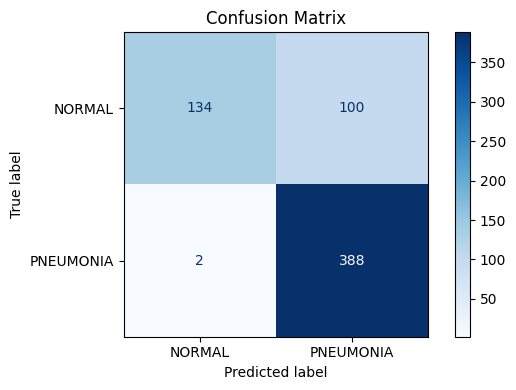

In [23]:
randomFC_h_metrics = evaluate_test_set_with_threshold(randomFC_h, X_test_h_flatten, y_test, final_threshold_h)
model_metrics_dict["randomFC_h"] = randomFC_h_metrics

Con soglia predefinita (0.5):
  - F1-score: 0.88
  - Precision: 0.79
  - Recall: 0.99

Con soglia ottimale (0.53):
  - F1-score: 0.89
  - Precision: 0.80
  - Recall: 0.99














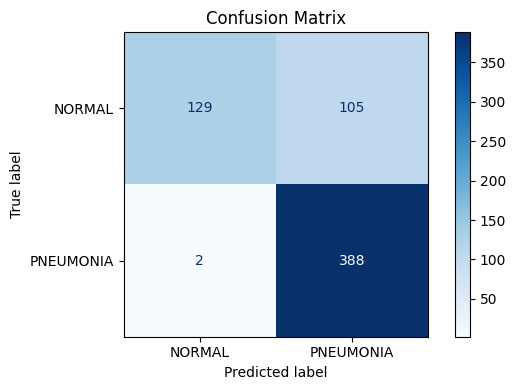

In [24]:
randomFC_m_metrics = evaluate_test_set_with_threshold(randomFC_m, X_test_m_flatten, y_test, final_threshold_m)
model_metrics_dict["randomFC_m"] = randomFC_m_metrics

Con soglia predefinita (0.5):
  - F1-score: 0.88
  - Precision: 0.79
  - Recall: 0.99

Con soglia ottimale (0.54):
  - F1-score: 0.90
  - Precision: 0.83
  - Recall: 0.99














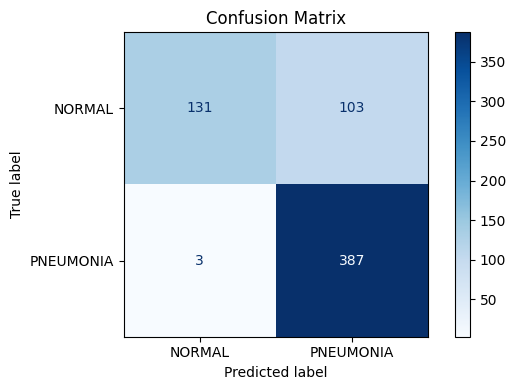

In [25]:
randomFC_l_metrics = evaluate_test_set_with_threshold(randomFC_l, X_test_l_flatten, y_test, final_threshold_l)
model_metrics_dict["randomFC_l"] = randomFC_l_metrics

## CNN
Dato che il dataset è composto da immagini, i prossimi modelli che si vanno a realizzare sono delle CNN.

È stato scelto un numero di epoche elevato per garantire un addestramento completo del modello. Tuttavia, è stata configurata una callback di Early Stopping per monitorare le prestazioni su un set di validazione. Questo permette di interrompere il training nel momento in cui non si osservano ulteriori miglioramenti significativi, evitando che il modello vada incontro a overfitting. Ripristiniamo, infine, i parametri dell'epoca con le migliori prestazioni assicurando che il modello mantenga una buona capacità di generalizzazione.

### Definizione modelli
La prima CNN si ispira a Lenet alternando livelli di pooling a livelli convoluzionali. La seconda invece si ispira a VGG(Visual Geometry Group) alternando due livelli convoluzionali ad un livello di pooling.

In [26]:
def build_cnn_simple(input_shapes):
    model = Sequential([
        Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=input_shapes),
        AveragePooling2D((2, 2), strides=2),
        Conv2D(32, (5, 5), activation='relu'),
        AveragePooling2D((2, 2), strides=2),
        Flatten(),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model


def build_cnn_complex(input_shapes):
    model = Sequential([
        Conv2D(16, (5, 5), padding='same', input_shape=input_shapes, activation='relu'),
        Conv2D(16, (5, 5), padding='same', activation='relu'),
        AveragePooling2D((2, 2), strides=2),
        Conv2D(32, (5, 5), padding='same', activation='relu'),
        Conv2D(32, (5, 5), padding='same', activation='relu'),
        AveragePooling2D((2, 2)),

        Flatten(),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

input_shape_h = X_train_h.shape[1:]
input_shape_m = X_train_m.shape[1:]
input_shape_l = X_train_l.shape[1:]

### Definizione funzioni per istanziare e valutare il modello

In [27]:
def compile_and_summarize_model(build_model_func, input_shape, loss='binary_crossentropy', metrics=None, optimizer='adam'):
    if metrics is None:
        metrics = ['accuracy', 'precision', 'recall']
    # Definisce il modello usando la funzione fornita in input
    model = build_model_func(input_shape)
    # Costruisce il modello
    model.build(input_shape=(None, *input_shape))
    # Stampa il riepilogo del modello
    model.summary()
    # Compila il modello
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model


def evaluate_cnn_model(model, X_valid, y_valid, X_test, y_test, history=None, graphics_func=None):

    # Predizioni sul set di validazione
    y_valid_proba = model.predict(X_valid)
    y_valid_pred = np.round(y_valid_proba).astype(int)

    # Calcolo del F1-score sul set di validazione
    valid_f1 = f1_score(y_valid, y_valid_pred)
    print(f"F1-score sul set di validazione: {valid_f1:.2f}")

    # Predizioni sul set di test
    y_test_proba = model.predict(X_test)
    y_test_pred = np.round(y_test_proba).astype(int)

    # Calcolo delle metriche sul set di test
    test_f1 = f1_score(y_test, y_test_pred)
    print(f"F1-score sul set di test: {test_f1:.2f}")

    test_precision = precision_score(y_test, y_test_pred)
    print(f"Precision sul set di test: {test_precision:.2f}")

    test_recall = recall_score(y_test, y_test_pred)
    print(f"Recall sul set di test: {test_recall:.2f}")

    # Generazione dei grafici se la funzione è fornita
    if graphics_func and history:
        graphics_func(y_test, y_test_pred, history)

    # Restituzione delle metriche in un dizionario
    return {
        'valid_f1': valid_f1,
        'test_f1': test_f1,
        'test_precision': test_precision,
        'test_recall': test_recall
    }


### CNN SIMPLE

In [28]:
cnn_simple_h = compile_and_summarize_model(build_cnn_simple, input_shape_h)
cnn_simple_m = compile_and_summarize_model(build_cnn_simple, input_shape_m)
cnn_simple_l = compile_and_summarize_model(build_cnn_simple, input_shape_l)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 14, 14, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          62,730 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,989 (296.83 KB)

 Trainable params: 75,989 (296.83 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 24, 24, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 10, 10, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          32,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,269 (176.83 KB)

 Trainable params: 45,269 (176.83 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 16, 16, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 6, 6, 32)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │          11,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,789 (96.83 KB)

 Trainable params: 24,789 (96.83 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history_cnn_simple_h = cnn_simple_h.fit(X_train_h, y_train, validation_data=(X_valid_h, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7846 - loss: 0.4970 - precision: 0.7816 - recall: 0.9904 - val_accuracy: 0.9351 - val_loss: 0.1759 - val_precision: 0.9351 - val_recall: 0.9823
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9288 - loss: 0.1768 - precision: 0.9425 - recall: 0.9633 - val_accuracy: 0.9465 - val_loss: 0.1394 - val_precision: 0.9792 - val_recall: 0.9495
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9450 - loss: 0.1364 - precision: 0.9581 - recall: 0.9686 - val_accuracy: 0.9351 - val_loss: 0.1529 - val_precision: 0.9879 - val_recall: 0.9255
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9393 - loss: 0.1432 - precision: 0.9566 - recall: 0.9625 - val_accuracy: 0.9494 - val_loss: 0.1236 - val_precision: 0.9868 - val_recall: 0.9457
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9499 - loss: 0.1285 - precision: 0.9668 - recall: 0.9660 - val_accuracy: 0.9656 - 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1-score sul set di validazione: 0.98
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1-score sul set di test: 0.89
Precision sul set di test: 0.82
Recall sul set di test: 0.98












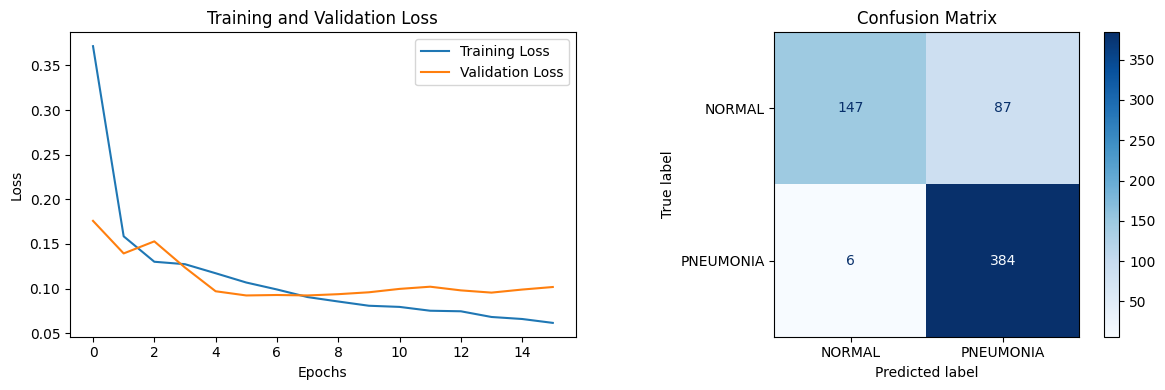

In [30]:
cnn_simple_h_metrics = evaluate_cnn_model(cnn_simple_h, X_valid_h, y_valid, X_test_h, y_test, history_cnn_simple_h, graphics)
model_metrics_dict["cnn_simple_h"] = cnn_simple_h_metrics

In [31]:
history_cnn_simple_m = cnn_simple_m.fit(X_train_m, y_train, validation_data=(X_valid_m, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7229 - loss: 0.5559 - precision: 0.7410 - recall: 0.9558 - val_accuracy: 0.8787 - val_loss: 0.3589 - val_precision: 0.9663 - val_recall: 0.8699
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8956 - loss: 0.3083 - precision: 0.8950 - recall: 0.9747 - val_accuracy: 0.9045 - val_loss: 0.3283 - val_precision: 0.9901 - val_recall: 0.8826
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9153 - loss: 0.2772 - precision: 0.9398 - recall: 0.9480 - val_accuracy: 0.9456 - val_loss: 0.2421 - val_precision: 0.9829 - val_recall: 0.9444
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9306 - loss: 0.2416 - precision: 0.9456 - recall: 0.9626 - val_accuracy: 0.9427 - val_loss: 0.2188 - val_precision: 0.9791 - val_recall: 0.9444
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9351 - loss: 0.2262 - precision: 0.9488 - recall: 0.9653 - val_accuracy: 0.9427 - v

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1-score sul set di validazione: 0.98
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1-score sul set di test: 0.90
Precision sul set di test: 0.82
Recall sul set di test: 0.99












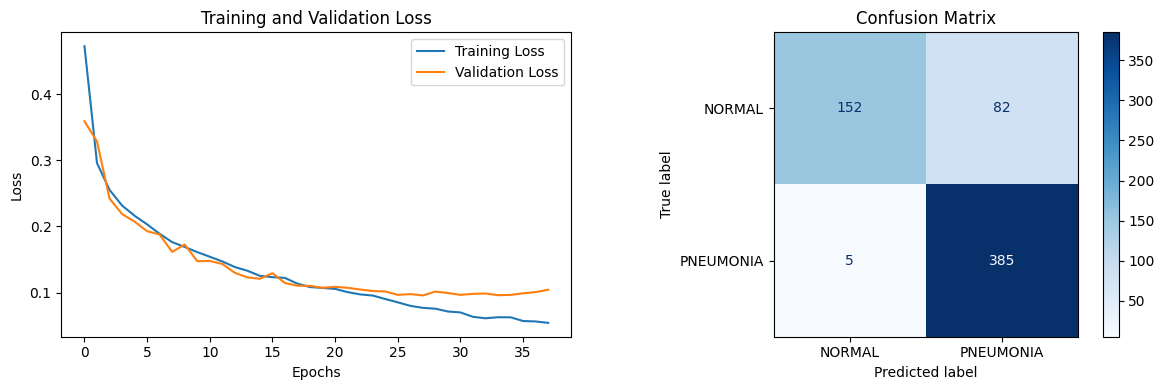

In [32]:
cnn_simple_m_metrics = evaluate_cnn_model(cnn_simple_m, X_valid_m, y_valid, X_test_m, y_test, history_cnn_simple_m, graphics)
model_metrics_dict["cnn_simple_m"] = cnn_simple_m_metrics

In [33]:
history_cnn_simple_l = cnn_simple_l.fit(X_train_l, y_train, validation_data=(X_valid_l, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7480 - loss: 0.5511 - precision: 0.7477 - recall: 0.9993 - val_accuracy: 0.8921 - val_loss: 0.3722 - val_precision: 0.9461 - val_recall: 0.9091
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8777 - loss: 0.3317 - precision: 0.8752 - recall: 0.9757 - val_accuracy: 0.9322 - val_loss: 0.2722 - val_precision: 0.9445 - val_recall: 0.9672
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9150 - loss: 0.2752 - precision: 0.9243 - recall: 0.9649 - val_accuracy: 0.9408 - val_loss: 0.2475 - val_precision: 0.9692 - val_recall: 0.9520
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9263 - loss: 0.2554 - precision: 0.9446 - recall: 0.9572 - val_accuracy: 0.9370 - val_loss: 0.2437 - val_precision: 0.9827 - val_recall: 0.9331
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9284 - loss: 0.2413 - precision: 0.9520 - recall: 0.9522 - val_accuracy: 0.9484 - v

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1-score sul set di validazione: 0.98
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1-score sul set di test: 0.92
Precision sul set di test: 0.86
Recall sul set di test: 0.98












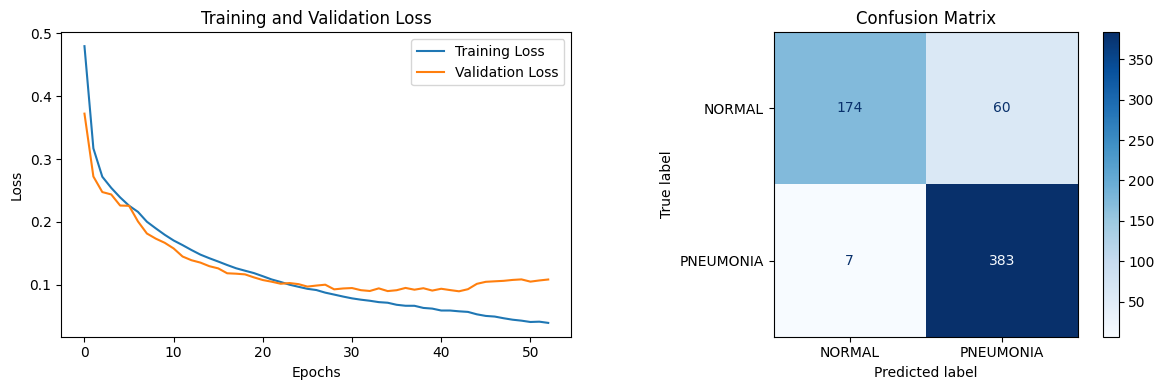

In [34]:
cnn_simple_l_metrics = evaluate_cnn_model(cnn_simple_l, X_valid_l, y_valid, X_test_l, y_test, history_cnn_simple_l, graphics)
model_metrics_dict["cnn_simple_l"] = cnn_simple_l_metrics

### CNN COMPLEX

In [35]:
cnn_complex_h = compile_and_summarize_model(build_cnn_complex, input_shape_h)
cnn_complex_m = compile_and_summarize_model(build_cnn_complex, input_shape_m)
cnn_complex_l = compile_and_summarize_model(build_cnn_complex, input_shape_l)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ (None, 32, 32, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_7                  │ (None, 16, 16, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │          81,930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 127,237 (497.02 KB)

 Trainable params: 127,237 (497.02 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 48, 48, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 48, 48, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_8                  │ (None, 24, 24, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_9                  │ (None, 12, 12, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │          46,090 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,397 (357.02 KB)

 Trainable params: 91,397 (357.02 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_10                 │ (None, 16, 16, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 16, 16, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 16, 16, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_11                 │ (None, 8, 8, 32)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │          20,490 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,797 (257.02 KB)

 Trainable params: 65,797 (257.02 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history_cnn_complex_h = cnn_complex_h.fit(X_train_h, y_train, validation_data=(X_valid_h, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7603 - loss: 0.5159 - precision: 0.7575 - recall: 0.9988 - val_accuracy: 0.8930 - val_loss: 0.2898 - val_precision: 0.8881 - val_recall: 0.9823
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9029 - loss: 0.2861 - precision: 0.9065 - recall: 0.9699 - val_accuracy: 0.9580 - val_loss: 0.2214 - val_precision: 0.9746 - val_recall: 0.9697
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9473 - loss: 0.2298 - precision: 0.9514 - recall: 0.9794 - val_accuracy: 0.9522 - val_loss: 0.2196 - val_precision: 0.9481 - val_recall: 0.9912
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9472 - loss: 0.2181 - precision: 0.9623 - recall: 0.9671 - val_accuracy: 0.9513 - val_loss: 0.2182 - val_precision: 0.9491 - val_recall: 0.9886
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9516 - loss: 0.2038 - precision: 0.9700 - recall: 0.9647 - val_accuracy: 0.965

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
F1-score sul set di validazione: 0.98
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
F1-score sul set di test: 0.91
Precision sul set di test: 0.83
Recall sul set di test: 0.99












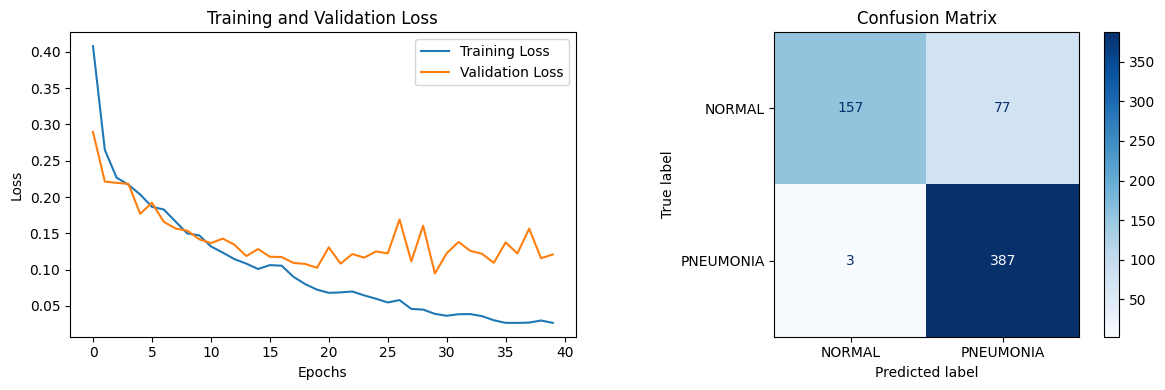

In [37]:
cnn_complex_h_metrics = evaluate_cnn_model(cnn_complex_h, X_valid_h, y_valid, X_test_h, y_test, history_cnn_complex_h, graphics)
model_metrics_dict["cnn_complex_h"] = cnn_complex_h_metrics

In [38]:
history_cnn_complex_m = cnn_complex_m.fit(X_train_m, y_train, validation_data=(X_valid_m, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7508 - loss: 0.5507 - precision: 0.7499 - recall: 0.9991 - val_accuracy: 0.9007 - val_loss: 0.2651 - val_precision: 0.8927 - val_recall: 0.9874
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9072 - loss: 0.2870 - precision: 0.9102 - recall: 0.9712 - val_accuracy: 0.9198 - val_loss: 0.2812 - val_precision: 0.9784 - val_recall: 0.9141
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9299 - loss: 0.2503 - precision: 0.9385 - recall: 0.9700 - val_accuracy: 0.9360 - val_loss: 0.2670 - val_precision: 0.9905 - val_recall: 0.9242
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9317 - loss: 0.2350 - precision: 0.9421 - recall: 0.9683 - val_accuracy: 0.9608 - val_loss: 0.1932 - val_precision: 0.9771 - val_recall: 0.9710
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9486 - loss: 0.2075 - precision: 0.9612 - recall: 0.9704 - val_accuracy: 0.9408 - v

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
F1-score sul set di validazione: 0.99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1-score sul set di test: 0.91
Precision sul set di test: 0.84
Recall sul set di test: 0.99












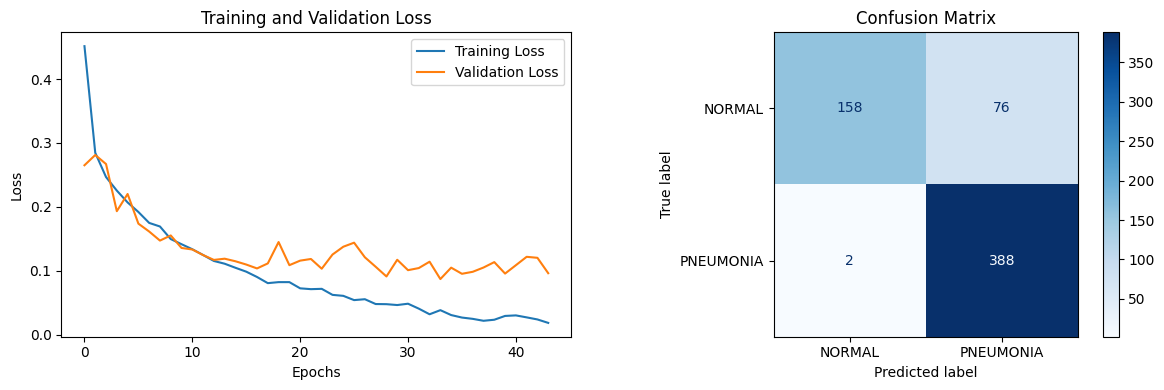

In [39]:
cnn_complex_m_metrics = evaluate_cnn_model(cnn_complex_m, X_valid_m, y_valid, X_test_m, y_test, history_cnn_complex_m, graphics)
model_metrics_dict["cnn_complex_m"] = cnn_complex_m_metrics

In [40]:
history_cnn_complex_l = cnn_complex_l.fit(X_train_l, y_train, validation_data=(X_valid_l, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7492 - loss: 0.5561 - precision: 0.7484 - recall: 0.9997 - val_accuracy: 0.8214 - val_loss: 0.3018 - val_precision: 0.8109 - val_recall: 0.9962
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8880 - loss: 0.3051 - precision: 0.8973 - recall: 0.9597 - val_accuracy: 0.9322 - val_loss: 0.2709 - val_precision: 0.9775 - val_recall: 0.9318
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9283 - loss: 0.2530 - precision: 0.9483 - recall: 0.9563 - val_accuracy: 0.9322 - val_loss: 0.2481 - val_precision: 0.9865 - val_recall: 0.9230
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9329 - loss: 0.2351 - precision: 0.9599 - recall: 0.9500 - val_accuracy: 0.9331 - val_loss: 0.2399 - val_precision: 0.9918 - val_recall: 0.9192
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9383 - loss: 0.1740 - precision: 0.9669 - recall: 0.9501 - val_accuracy: 0.9322 - v

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
F1-score sul set di validazione: 0.98
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
F1-score sul set di test: 0.91
Precision sul set di test: 0.84
Recall sul set di test: 0.98












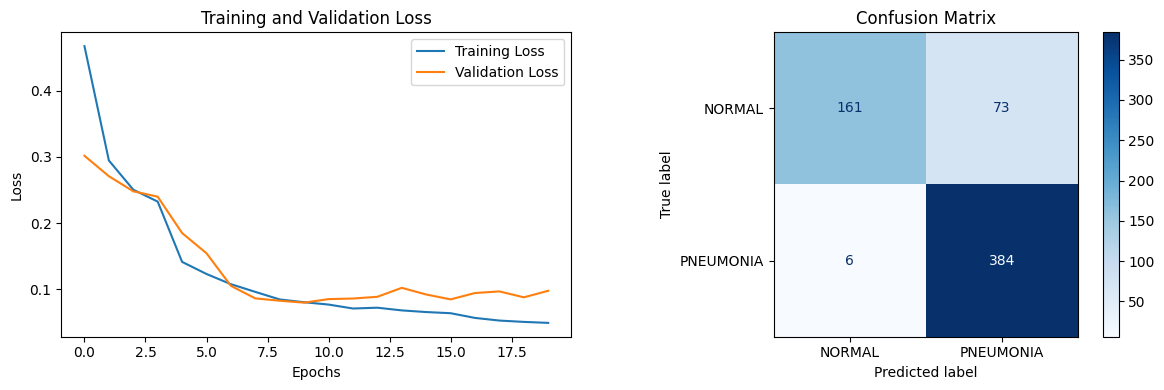

In [41]:
cnn_complex_l_metrics = evaluate_cnn_model(cnn_complex_l, X_valid_l, y_valid, X_test_l, y_test, history_cnn_complex_l, graphics)
model_metrics_dict["cnn_complex_l"] = cnn_complex_l_metrics

###CNN COMPLEX REGOLARIZZATA

Aggiunguamo le seguenti tecniche di regolarizzazione per rendere più stabile l'addestramento della seconda rete:  
* **He Normalization**: metodo di inizializzazione dei pesi delle reti neurali che funziona molto bene con ReLU
* **L2**: tecnica di regolarizzazione che va ad aggiungere un termine alla funzione di perdita che penalizza i pesi grandi durante l'addestramento
* **ReduceLROnPlateau**: callback di Keras che riduce il learning rate quando una metrica monitorata smette di migliorare. È utile per accelerare il processo di addestramento e migliorare la convergenza del modello.
* **Dropout**: tecnica di regolarizzazione che, durante l'addestramento, spegne casualmente una percentuale di neuroni in ciascun layer per ridurre l'overfitting. Questo impedisce al modello di dipendere troppo da specifiche connessioni, migliorandone la capacità di generalizzazione.
* **LayerNorm**: tecnica di normalizzazione applicata ai layer, utile per stabilizzare e accelerare l'addestramento delle reti neurali. Normalizza l'attivazione dei neuroni rispetto a tutte le feature di un dato layer, migliorando la robustezza e riducendo l'effetto di gradienti instabili.

Definizione modello regolarizzato

In [42]:
def build_cnn_complex_reg(input_shapes):
    model = Sequential([
        Conv2D(16, (5, 5), padding='same', input_shape=input_shapes, activation='relu', kernel_regularizer=L2(l2=0.001), kernel_initializer=he_normal()),
        Conv2D(16, (5, 5), padding='same', activation='relu', kernel_regularizer=L2(l2=0.003), kernel_initializer=he_normal()),
        AveragePooling2D((2, 2), strides=2),
        Dropout(0.3),
        LayerNormalization(),
        Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=L2(l2=0.003), kernel_initializer=he_normal()),
        Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=L2(l2=0.005), kernel_initializer=he_normal()),
        AveragePooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        LayerNormalization(),
        Dropout(0.7),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [43]:
cnn_complex_reg_h = compile_and_summarize_model(build_cnn_complex_reg, input_shape_h)
cnn_complex_reg_m = compile_and_summarize_model(build_cnn_complex_reg, input_shape_m)
cnn_complex_reg_l = compile_and_summarize_model(build_cnn_complex_reg, input_shape_l)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 64, 64, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 64, 64, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_12                 │ (None, 32, 32, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 32, 32, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 32, 32, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_13                 │ (None, 16, 16, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 8192)                │          16,384 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │          81,930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 143,653 (561.14 KB)

 Trainable params: 143,653 (561.14 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 48, 48, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 48, 48, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_14                 │ (None, 24, 24, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (None, 24, 24, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 24, 24, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 24, 24, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_15                 │ (None, 12, 12, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_3                │ (None, 4608)                │           9,216 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │          46,090 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,645 (393.14 KB)

 Trainable params: 100,645 (393.14 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 32, 32, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 32, 32, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_16                 │ (None, 16, 16, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_4                │ (None, 16, 16, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 16, 16, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 16, 16, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_17                 │ (None, 8, 8, 32)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_5                │ (None, 2048)                │           4,096 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 10)                  │          20,490 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,925 (273.14 KB)

 Trainable params: 69,925 (273.14 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history_cnn_complex_reg_h = cnn_complex_reg_h.fit(X_train_h, y_train, validation_data=(X_valid_h, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), reduce_lr])

Epoch 1/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7130 - loss: 1.1831 - precision: 0.7454 - recall: 0.9351 - val_accuracy: 0.7564 - val_loss: 0.7646 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7510 - loss: 0.7558 - precision: 0.7505 - recall: 0.9977 - val_accuracy: 0.9245 - val_loss: 0.4655 - val_precision: 0.9672 - val_recall: 0.9318 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8876 - loss: 0.4701 - precision: 0.8914 - recall: 0.9678 - val_accuracy: 0.9312 - val_loss: 0.2933 - val_precision: 0.9306 - val_recall: 0.9823 - learning_rate: 0.0010
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9230 - loss: 0.3192 - precision: 0.9433 - recall: 0.9542 - val_accuracy: 0.9503 - val_loss: 0.2322 - val_precision: 0.9881 - val_recall: 0.9457 - learning_rate: 0.0010
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/st

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
F1-score sul set di validazione: 0.99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
F1-score sul set di test: 0.89
Precision sul set di test: 0.81
Recall sul set di test: 1.00












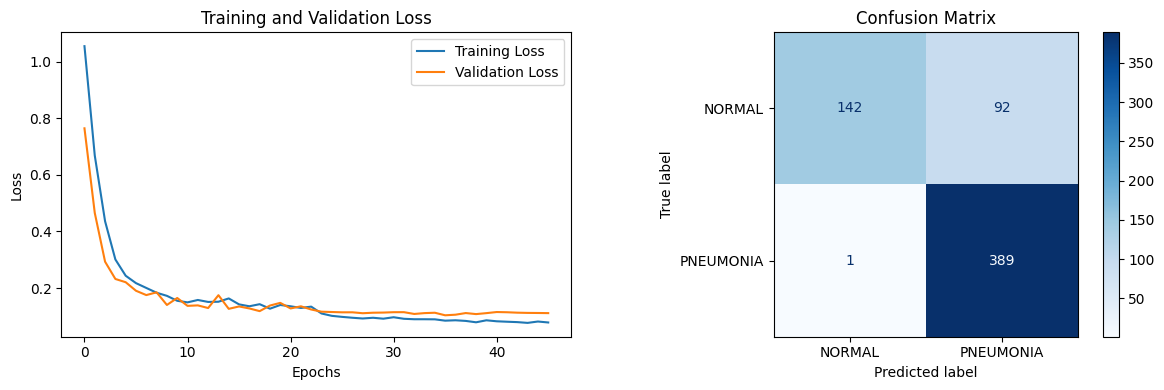

In [45]:
cnn_complex_reg_h_metrics = evaluate_cnn_model(cnn_complex_reg_h, X_valid_h, y_valid, X_test_h, y_test, history_cnn_complex_reg_h, graphics)
model_metrics_dict["cnn_complex_reg_h"] = cnn_complex_reg_h_metrics

In [46]:
history_cnn_complex_reg_m = cnn_complex_reg_m.fit(X_train_m, y_train, validation_data=(X_valid_m, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), reduce_lr])

Epoch 1/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6994 - loss: 1.3072 - precision: 0.7463 - recall: 0.9161 - val_accuracy: 0.7564 - val_loss: 0.9217 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7457 - loss: 0.8695 - precision: 0.7457 - recall: 1.0000 - val_accuracy: 0.7564 - val_loss: 0.7638 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7454 - loss: 0.7135 - precision: 0.7464 - recall: 0.9975 - val_accuracy: 0.7564 - val_loss: 0.4820 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7760 - loss: 0.4938 - precision: 0.7739 - recall: 0.9909 - val_accuracy: 0.9417 - val_loss: 0.3638 - val_precision: 0.9692 - val_recall: 0.9533 - learning_rate: 0.0010
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/st

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
F1-score sul set di validazione: 0.99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1-score sul set di test: 0.90
Precision sul set di test: 0.83
Recall sul set di test: 1.00












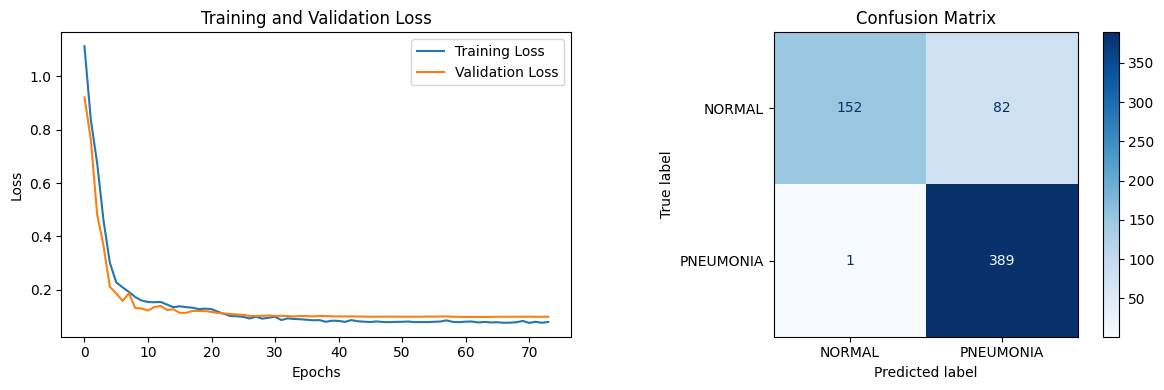

In [47]:
cnn_complex_reg_m_metrics = evaluate_cnn_model(cnn_complex_reg_m, X_valid_m, y_valid, X_test_m, y_test, history_cnn_complex_reg_m, graphics)
model_metrics_dict["cnn_complex_reg_m"] = cnn_complex_reg_m_metrics

In [48]:
history_cnn_complex_reg_l = cnn_complex_reg_l.fit(X_train_l, y_train, validation_data=(X_valid_l, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), reduce_lr])

Epoch 1/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7239 - loss: 1.2111 - precision: 0.7434 - recall: 0.9636 - val_accuracy: 0.7564 - val_loss: 0.8922 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7457 - loss: 0.8573 - precision: 0.7457 - recall: 1.0000 - val_accuracy: 0.7564 - val_loss: 0.7418 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7457 - loss: 0.7152 - precision: 0.7457 - recall: 1.0000 - val_accuracy: 0.7564 - val_loss: 0.5909 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7457 - loss: 0.6342 - precision: 0.7458 - recall: 0.9997 - val_accuracy: 0.7564 - val_loss: 0.3972 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/st

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
F1-score sul set di validazione: 0.99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1-score sul set di test: 0.90
Precision sul set di test: 0.82
Recall sul set di test: 0.99












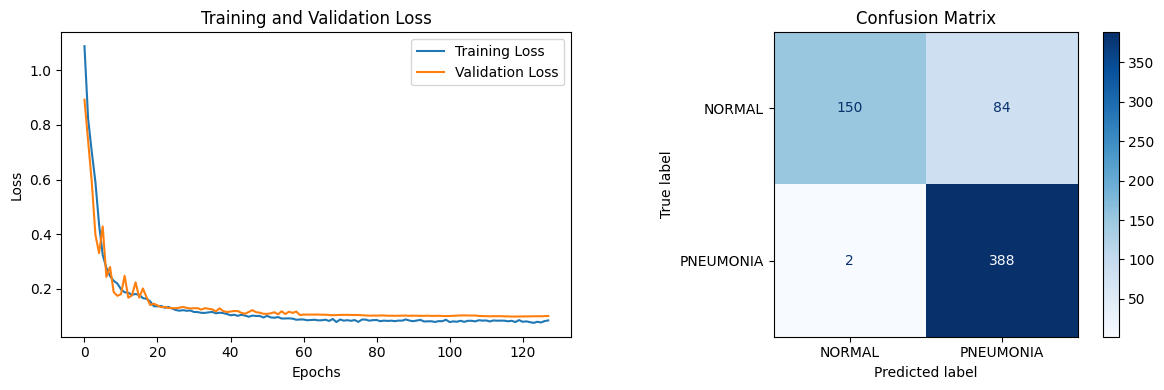

In [49]:
cnn_complex_reg_l_metrics = evaluate_cnn_model(cnn_complex_reg_l, X_valid_l, y_valid, X_test_l, y_test, history_cnn_complex_reg_l, graphics)
model_metrics_dict["cnn_complex_reg_l"] = cnn_complex_reg_l_metrics

### Risultati
Le reti sviluppate non generalizzano adeguatamente sui nuovi dati, evidenziando la presenza di overfitting.

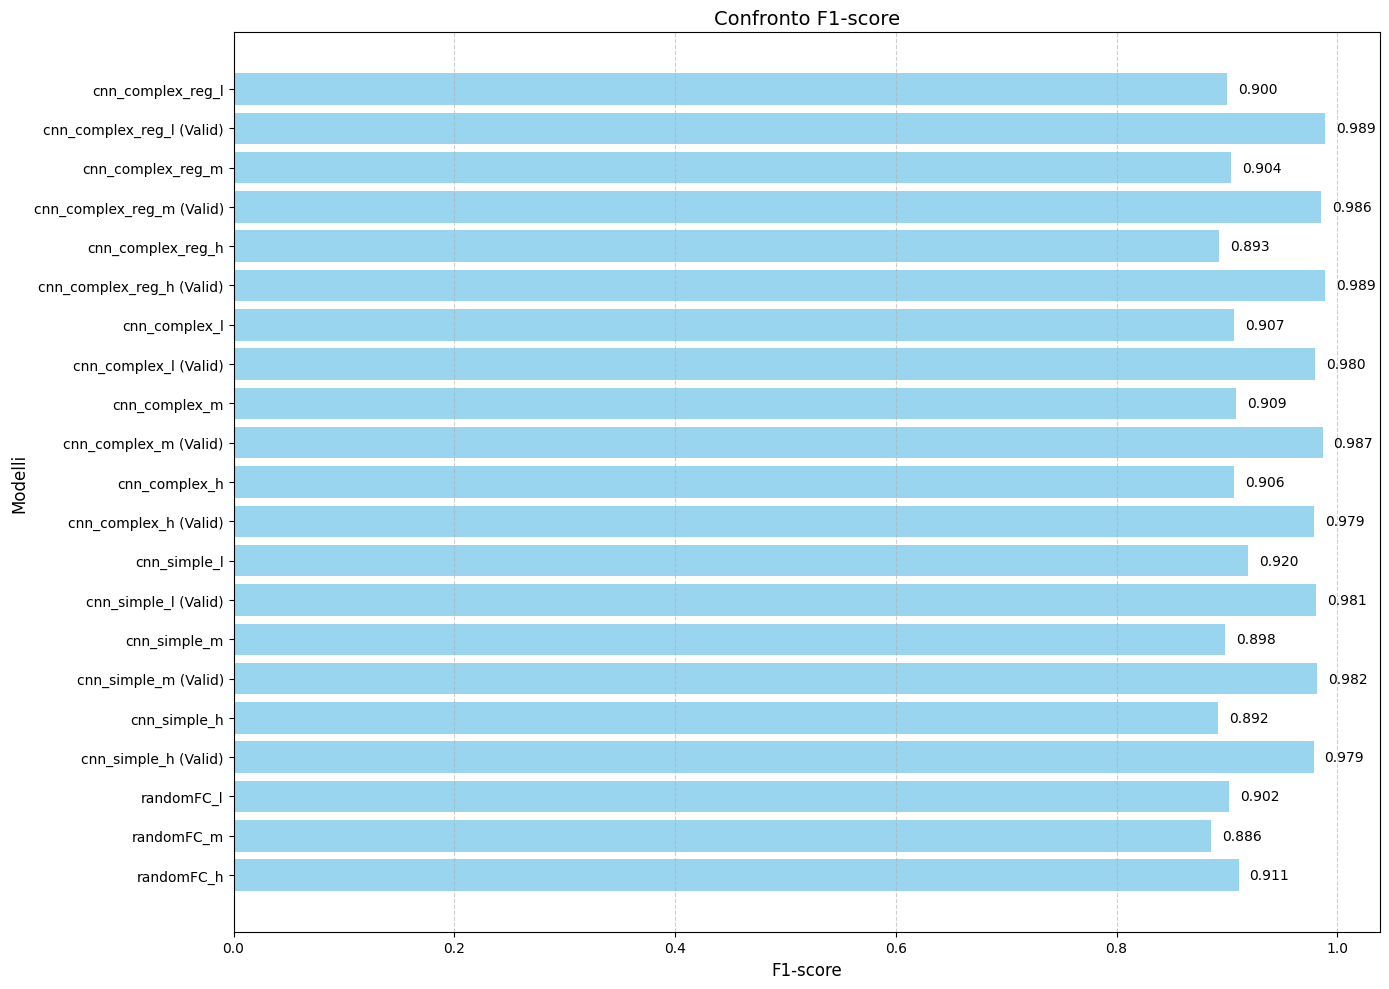

In [50]:
plot_f1_scores(model_metrics_dict, augmented=False, validation=True, rf=True, onlyAug=False)

### Dataset augmentation
Il modo più efficace per migliorare la capacità di generalizzazione di un modello è addestrarlo su un maggior numero di dati. Tuttavia, nella maggior parte dei casi, la quantità di dati disponibili è limitata.  

Le tecniche di data augmentation permettono di ampliare artificialmente la dimensione e la variabilità del dataset di training, generando nuovi campioni a partire da quelli esistenti tramite opportune trasformazioni.

#### Definizione generatori
Le tecniche utilizzate sono state suddivise in tre configurazioni distinte:

1.   Alta variazione
2.   Media variazione
3.   Bassa variazione

Questa suddivisione consente di valutare come variabilità diverse influiscano sulle prestazioni del modello.

In [51]:
train_datagen_h = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    vertical_flip=False,
    horizontal_flip=False,
    fill_mode='nearest'
)

train_datagen_m = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    vertical_flip=False,
    horizontal_flip=False,
    fill_mode='nearest'
)

train_datagen_l = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.075,
    width_shift_range=0.075,
    height_shift_range=0.075,
    shear_range=0.075,
    vertical_flip=False,
    horizontal_flip=False,
    fill_mode='nearest'
)

In [52]:
train_generator_dh_h = train_datagen_h.flow(X_train_h, y_train, batch_size=32, seed=42)
train_generator_dh_m = train_datagen_h.flow(X_train_m, y_train, batch_size=32, seed=42)
train_generator_dh_l = train_datagen_h.flow(X_train_l, y_train, batch_size=32, seed=42)

train_generator_dm_h = train_datagen_m.flow(X_train_h, y_train, batch_size=32, seed=42)
train_generator_dm_m = train_datagen_m.flow(X_train_m, y_train, batch_size=32, seed=42)
train_generator_dm_l = train_datagen_m.flow(X_train_l, y_train, batch_size=32, seed=42)

train_generator_dl_h = train_datagen_l.flow(X_train_h, y_train, batch_size=32, seed=42)
train_generator_dl_m = train_datagen_l.flow(X_train_m, y_train, batch_size=32, seed=42)
train_generator_dl_l = train_datagen_l.flow(X_train_l, y_train, batch_size=32, seed=42)

#### Alta variazione

In [53]:
cnn_complex_dh_h_aug = compile_and_summarize_model(build_cnn_complex_reg, input_shape_h)
cnn_complex_dh_m_aug = compile_and_summarize_model(build_cnn_complex_reg, input_shape_m)
cnn_complex_dh_l_aug = compile_and_summarize_model(build_cnn_complex_reg, input_shape_l)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 64, 64, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 64, 64, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_18                 │ (None, 32, 32, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_6                │ (None, 32, 32, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 32, 32, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 32, 32, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_19                 │ (None, 16, 16, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_7                │ (None, 8192)                │          16,384 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 10)                  │          81,930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 143,653 (561.14 KB)

 Trainable params: 143,653 (561.14 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)                   │ (None, 48, 48, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 48, 48, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_20                 │ (None, 24, 24, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_8                │ (None, 24, 24, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 24, 24, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 24, 24, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_21                 │ (None, 12, 12, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_9                │ (None, 4608)                │           9,216 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │          46,090 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,645 (393.14 KB)

 Trainable params: 100,645 (393.14 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)                   │ (None, 32, 32, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 32, 32, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_22                 │ (None, 16, 16, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_10               │ (None, 16, 16, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 16, 16, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 16, 16, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_23                 │ (None, 8, 8, 32)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_11               │ (None, 2048)                │           4,096 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10)                  │          20,490 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,925 (273.14 KB)

 Trainable params: 69,925 (273.14 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
history_cnn_complex_dh_h = cnn_complex_dh_h_aug.fit(train_generator_dh_h, validation_data=(X_valid_h, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), reduce_lr])

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.7258 - loss: 1.1648 - precision: 0.7349 - recall: 0.9792 - val_accuracy: 0.7564 - val_loss: 0.8137 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7422 - loss: 0.7757 - precision: 0.7456 - recall: 0.9906 - val_accuracy: 0.7402 - val_loss: 0.6628 - val_precision: 0.7579 - val_recall: 0.9646 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7469 - loss: 0.6188 - precision: 0.7705 - recall: 0.9436 - val_accuracy: 0.7230 - val_loss: 0.5758 - val_precision: 0.8153 - val_recall: 0.8194 - learning_rate: 0.0010
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.7504 - loss: 0.5646 - precision: 0.8431 - recall: 0.8145 - val_accuracy: 0.6963 - val_loss: 0.5336 - val_precision: 0.8873 - val_recall: 0.6856 - learning_rate: 0.0010
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accur

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
F1-score sul set di validazione: 0.85
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
F1-score sul set di test: 0.76
Precision sul set di test: 0.77
Recall sul set di test: 0.76












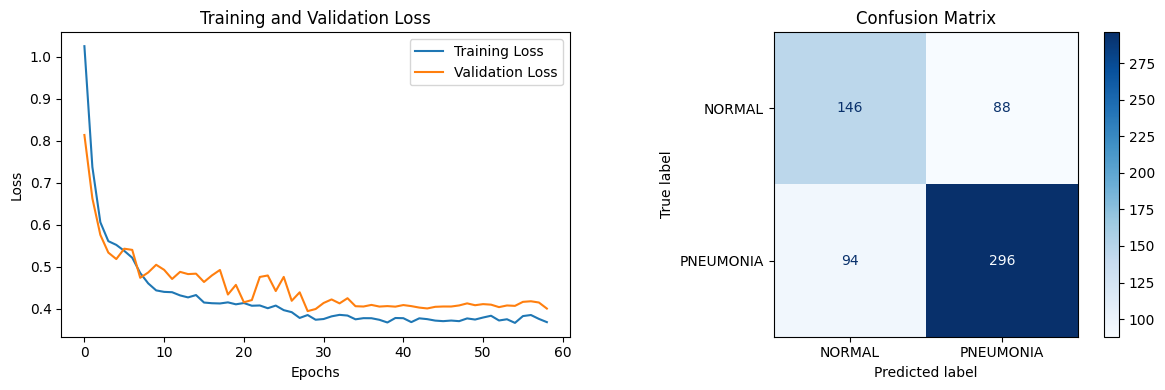

In [55]:
cnn_complex_dh_h_aug_metrics = evaluate_cnn_model(cnn_complex_dh_h_aug, X_valid_h, y_valid, X_test_h, y_test, history_cnn_complex_dh_h, graphics)
model_metrics_dict["cnn_complex_dh_h"] = cnn_complex_dh_h_aug_metrics

In [56]:
history_cnn_complex_dh_m = cnn_complex_dh_m_aug.fit(train_generator_dh_m, validation_data=(X_valid_m, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), reduce_lr])

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.7186 - loss: 1.2018 - precision: 0.7386 - recall: 0.9545 - val_accuracy: 0.7564 - val_loss: 0.8972 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7448 - loss: 0.8181 - precision: 0.7458 - recall: 0.9970 - val_accuracy: 0.7564 - val_loss: 0.8187 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7555 - loss: 0.6519 - precision: 0.7564 - recall: 0.9976 - val_accuracy: 0.7564 - val_loss: 0.6191 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7312 - loss: 0.6053 - precision: 0.7334 - recall: 0.9953 - val_accuracy: 0.7564 - val_loss: 0.6143 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
F1-score sul set di validazione: 0.95
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1-score sul set di test: 0.94
Precision sul set di test: 0.90
Recall sul set di test: 0.97












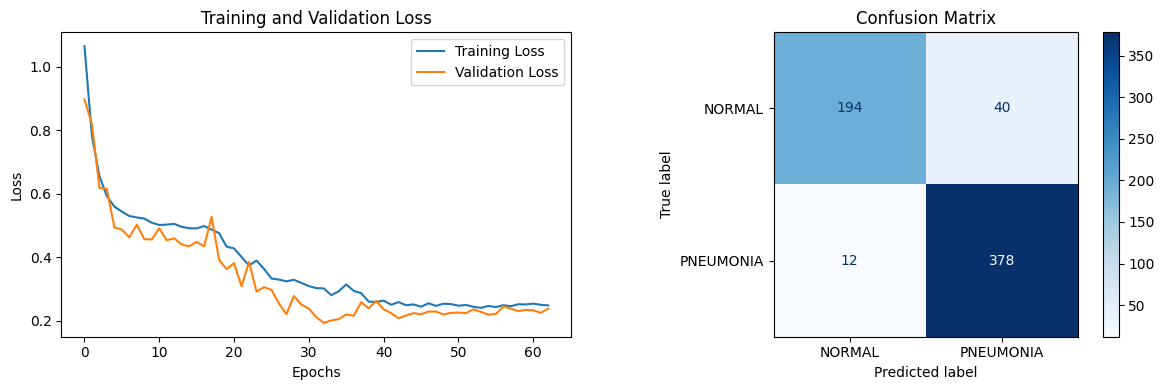

In [57]:
cnn_complex_dh_m_aug_metrics = evaluate_cnn_model(cnn_complex_dh_m_aug, X_valid_m, y_valid, X_test_m, y_test, history_cnn_complex_dh_m, graphics)
model_metrics_dict["cnn_complex_dh_m"] = cnn_complex_dh_m_aug_metrics

In [58]:
history_cnn_complex_dh_l = cnn_complex_dh_l_aug.fit(train_generator_dh_l, validation_data=(X_valid_l, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), reduce_lr])

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.6835 - loss: 1.2796 - precision: 0.7379 - recall: 0.8855 - val_accuracy: 0.7564 - val_loss: 0.9304 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7344 - loss: 0.8978 - precision: 0.7353 - recall: 0.9980 - val_accuracy: 0.7564 - val_loss: 0.7559 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7372 - loss: 0.7460 - precision: 0.7388 - recall: 0.9966 - val_accuracy: 0.7564 - val_loss: 0.7115 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7337 - loss: 0.6683 - precision: 0.7378 - recall: 0.9910 - val_accuracy: 0.7564 - val_loss: 0.6428 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
F1-score sul set di validazione: 0.86
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1-score sul set di test: 0.77
Precision sul set di test: 0.62
Recall sul set di test: 1.00












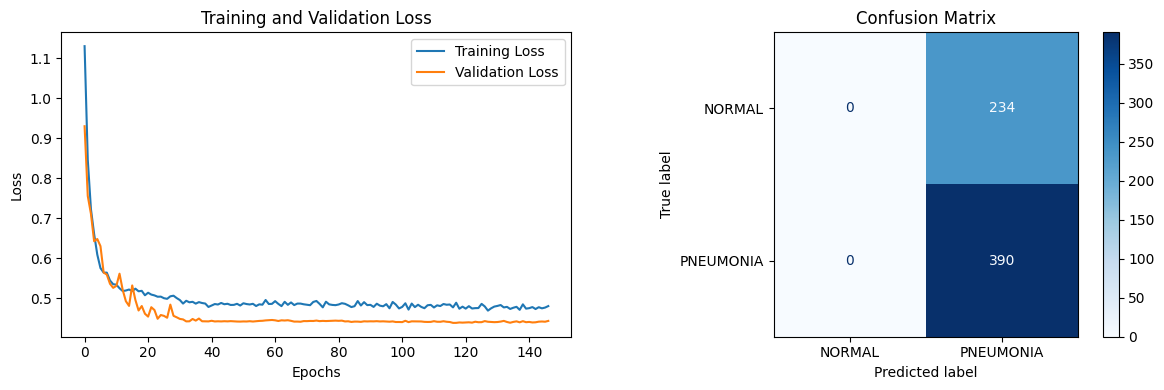

In [59]:
cnn_complex_dh_l_aug_metrics = evaluate_cnn_model(cnn_complex_dh_l_aug, X_valid_l, y_valid, X_test_l, y_test, history_cnn_complex_dh_l, graphics)
model_metrics_dict["cnn_complex_dh_l"] = cnn_complex_dh_l_aug_metrics

#### Media variazione

In [60]:
cnn_complex_dm_h_aug = compile_and_summarize_model(build_cnn_complex_reg, input_shape_h)
cnn_complex_dm_m_aug = compile_and_summarize_model(build_cnn_complex_reg, input_shape_m)
cnn_complex_dm_l_aug = compile_and_summarize_model(build_cnn_complex_reg, input_shape_l)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)                   │ (None, 64, 64, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 64, 64, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_24                 │ (None, 32, 32, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_12               │ (None, 32, 32, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 32, 32, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 32, 32, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_25                 │ (None, 16, 16, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_13               │ (None, 8192)                │          16,384 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 10)                  │          81,930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 143,653 (561.14 KB)

 Trainable params: 143,653 (561.14 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)                   │ (None, 48, 48, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 48, 48, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_26                 │ (None, 24, 24, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_14               │ (None, 24, 24, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 24, 24, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 24, 24, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_27                 │ (None, 12, 12, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_15               │ (None, 4608)                │           9,216 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 10)                  │          46,090 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,645 (393.14 KB)

 Trainable params: 100,645 (393.14 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)                   │ (None, 32, 32, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 32, 32, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_28                 │ (None, 16, 16, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_16               │ (None, 16, 16, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 16, 16, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 16, 16, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_29                 │ (None, 8, 8, 32)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_17               │ (None, 2048)                │           4,096 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 10)                  │          20,490 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,925 (273.14 KB)

 Trainable params: 69,925 (273.14 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
history_cnn_complex_dm_h = cnn_complex_dm_h_aug.fit(train_generator_dm_h, validation_data=(X_valid_h, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), reduce_lr])

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.7231 - loss: 1.1762 - precision: 0.7387 - recall: 0.9676 - val_accuracy: 0.7564 - val_loss: 0.8201 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7419 - loss: 0.7876 - precision: 0.7454 - recall: 0.9919 - val_accuracy: 0.7564 - val_loss: 0.6246 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7406 - loss: 0.6534 - precision: 0.7435 - recall: 0.9926 - val_accuracy: 0.7536 - val_loss: 0.5624 - val_precision: 0.7613 - val_recall: 0.9823 - learning_rate: 0.0010
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7457 - loss: 0.5722 - precision: 0.7742 - recall: 0.9277 - val_accuracy: 0.7603 - val_loss: 0.5074 - val_precision: 0.7593 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accurac

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
F1-score sul set di validazione: 0.92
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
F1-score sul set di test: 0.83
Precision sul set di test: 0.74
Recall sul set di test: 0.95












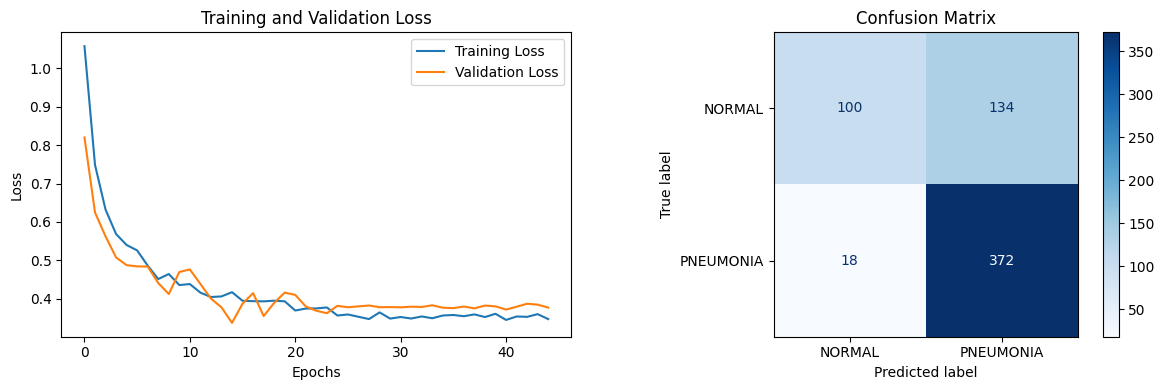

In [62]:
cnn_complex_dm_h_aug_metrics = evaluate_cnn_model(cnn_complex_dm_h_aug, X_valid_h, y_valid, X_test_h, y_test, history_cnn_complex_dm_h, graphics)
model_metrics_dict["cnn_complex_dm_h"] = cnn_complex_dm_h_aug_metrics

In [63]:
history_cnn_complex_dm_m = cnn_complex_dm_m_aug.fit(train_generator_dm_m, validation_data=(X_valid_m, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), reduce_lr])

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7103 - loss: 1.2235 - precision: 0.7463 - recall: 0.9297 - val_accuracy: 0.7564 - val_loss: 0.8981 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7331 - loss: 0.8781 - precision: 0.7340 - recall: 0.9981 - val_accuracy: 0.7564 - val_loss: 0.6577 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7358 - loss: 0.7138 - precision: 0.7436 - recall: 0.9813 - val_accuracy: 0.7507 - val_loss: 0.5708 - val_precision: 0.7555 - val_recall: 0.9912 - learning_rate: 0.0010
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7191 - loss: 0.6279 - precision: 0.7410 - recall: 0.9411 - val_accuracy: 0.7564 - val_loss: 0.5674 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
F1-score sul set di validazione: 0.97
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1-score sul set di test: 0.90
Precision sul set di test: 0.83
Recall sul set di test: 0.98












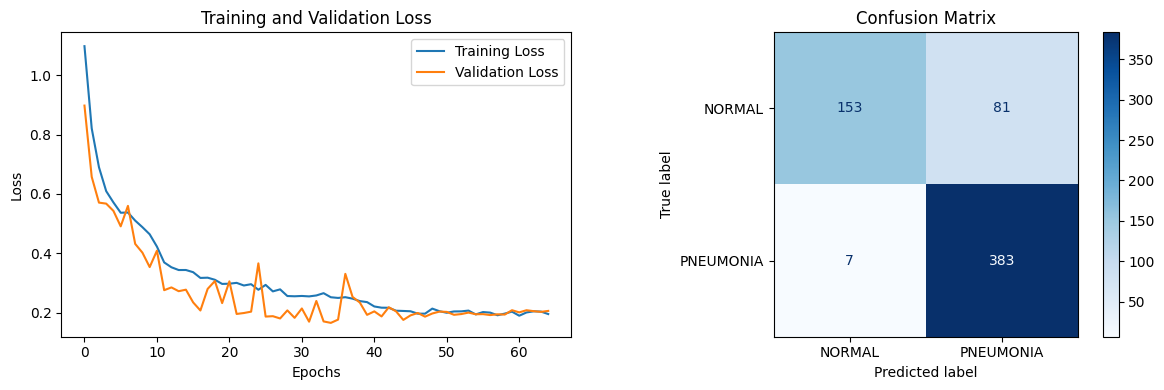

In [64]:
cnn_complex_dm_m_aug_metrics = evaluate_cnn_model(cnn_complex_dm_m_aug, X_valid_m, y_valid, X_test_m, y_test, history_cnn_complex_dm_m, graphics)
model_metrics_dict["cnn_complex_dm_m"] = cnn_complex_dm_m_aug_metrics

In [65]:
history_cnn_complex_dm_l = cnn_complex_dm_l_aug.fit(train_generator_dm_l, validation_data=(X_valid_l, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), reduce_lr])

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.6836 - loss: 1.2654 - precision: 0.7251 - recall: 0.9072 - val_accuracy: 0.7564 - val_loss: 0.9180 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7436 - loss: 0.8936 - precision: 0.7441 - recall: 0.9991 - val_accuracy: 0.7564 - val_loss: 0.7497 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7502 - loss: 0.7399 - precision: 0.7523 - recall: 0.9949 - val_accuracy: 0.7564 - val_loss: 0.7333 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7367 - loss: 0.6940 - precision: 0.7367 - recall: 1.0000 - val_accuracy: 0.7564 - val_loss: 0.6635 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
F1-score sul set di validazione: 0.97
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1-score sul set di test: 0.93
Precision sul set di test: 0.87
Recall sul set di test: 0.99












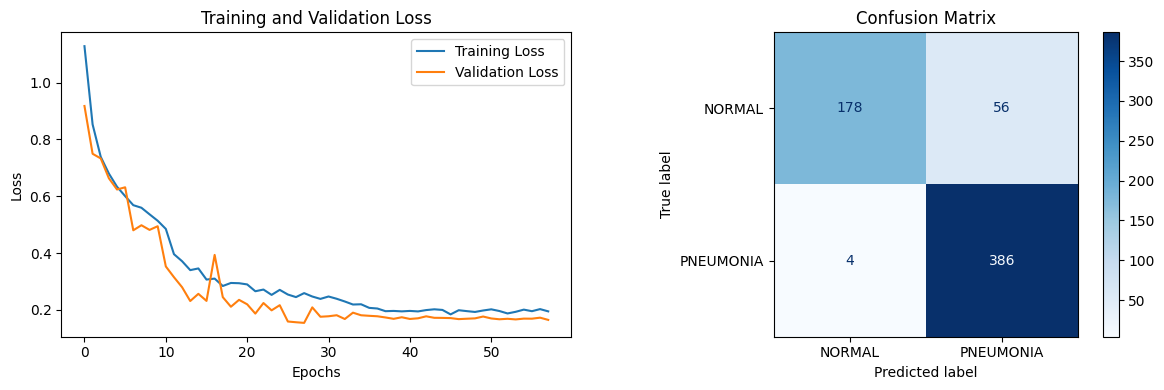

In [66]:
cnn_complex_dm_l_aug_metrics = evaluate_cnn_model(cnn_complex_dm_l_aug, X_valid_l, y_valid, X_test_l, y_test, history_cnn_complex_dm_l, graphics)
model_metrics_dict["cnn_complex_dm_l"] = cnn_complex_dm_l_aug_metrics

#### Bassa variazione

In [67]:
cnn_complex_dl_h_aug = compile_and_summarize_model(build_cnn_complex_reg, input_shape_h)
cnn_complex_dl_m_aug = compile_and_summarize_model(build_cnn_complex_reg, input_shape_m)
cnn_complex_dl_l_aug = compile_and_summarize_model(build_cnn_complex_reg, input_shape_l)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)                   │ (None, 64, 64, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 64, 64, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_30                 │ (None, 32, 32, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_18               │ (None, 32, 32, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 32, 32, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 32, 32, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_31                 │ (None, 16, 16, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_19               │ (None, 8192)                │          16,384 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 10)                  │          81,930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 143,653 (561.14 KB)

 Trainable params: 143,653 (561.14 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)                   │ (None, 48, 48, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 48, 48, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_32                 │ (None, 24, 24, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_20               │ (None, 24, 24, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 24, 24, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 24, 24, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_33                 │ (None, 12, 12, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_21               │ (None, 4608)                │           9,216 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 10)                  │          46,090 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,645 (393.14 KB)

 Trainable params: 100,645 (393.14 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_62 (Conv2D)                   │ (None, 32, 32, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 32, 32, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_34                 │ (None, 16, 16, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_22               │ (None, 16, 16, 16)          │              32 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 16, 16, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 16, 16, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_35                 │ (None, 8, 8, 32)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_23               │ (None, 2048)                │           4,096 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 10)                  │          20,490 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,925 (273.14 KB)

 Trainable params: 69,925 (273.14 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
history_cnn_complex_dl_h = cnn_complex_dl_h_aug.fit(train_generator_dl_h, validation_data=(X_valid_h, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), reduce_lr])

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.7121 - loss: 1.2176 - precision: 0.7385 - recall: 0.9454 - val_accuracy: 0.7564 - val_loss: 0.8415 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7377 - loss: 0.8281 - precision: 0.7433 - recall: 0.9865 - val_accuracy: 0.7564 - val_loss: 0.6097 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.7524 - loss: 0.6469 - precision: 0.7617 - recall: 0.9709 - val_accuracy: 0.8586 - val_loss: 0.4386 - val_precision: 0.9561 - val_recall: 0.8523 - learning_rate: 0.0010
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8472 - loss: 0.4860 - precision: 0.8922 - recall: 0.9026 - val_accuracy: 0.9284 - val_loss: 0.3085 - val_precision: 0.9686 - val_recall: 0.9356 - learning_rate: 0.0010
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accurac

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
F1-score sul set di validazione: 0.99
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
F1-score sul set di test: 0.91
Precision sul set di test: 0.84
Recall sul set di test: 0.99












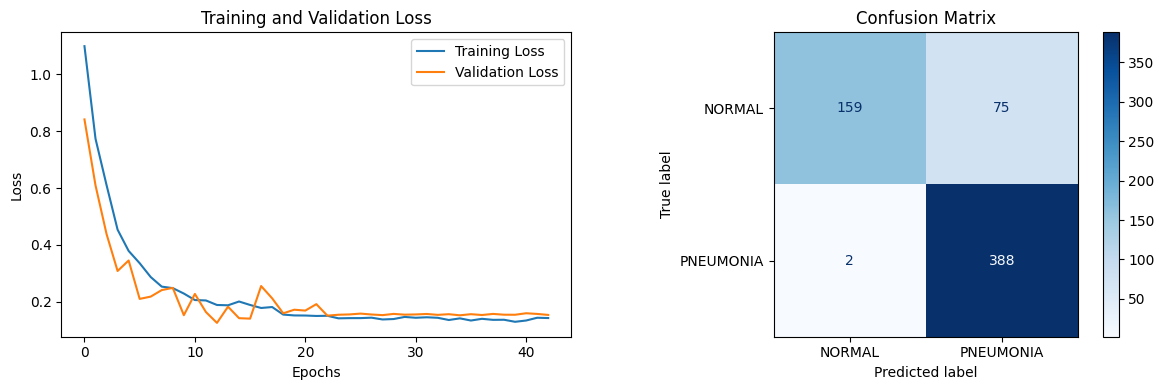

In [69]:
cnn_complex_dl_h_aug_metrics = evaluate_cnn_model(cnn_complex_dl_h_aug, X_valid_h, y_valid, X_test_h, y_test, history_cnn_complex_dl_h, graphics)
model_metrics_dict["cnn_complex_dl_h"] = cnn_complex_dl_h_aug_metrics

In [70]:
history_cnn_complex_dl_m = cnn_complex_dl_m_aug.fit(train_generator_dl_m, validation_data=(X_valid_m, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), reduce_lr])

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7001 - loss: 1.2324 - precision: 0.7342 - recall: 0.9342 - val_accuracy: 0.7564 - val_loss: 0.9128 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7304 - loss: 0.8573 - precision: 0.7311 - recall: 0.9987 - val_accuracy: 0.7564 - val_loss: 0.7205 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7333 - loss: 0.7278 - precision: 0.7366 - recall: 0.9928 - val_accuracy: 0.7564 - val_loss: 0.6673 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7528 - loss: 0.6697 - precision: 0.7528 - recall: 1.0000 - val_accuracy: 0.7564 - val_loss: 0.5450 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
F1-score sul set di validazione: 0.98
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1-score sul set di test: 0.94
Precision sul set di test: 0.89
Recall sul set di test: 0.99












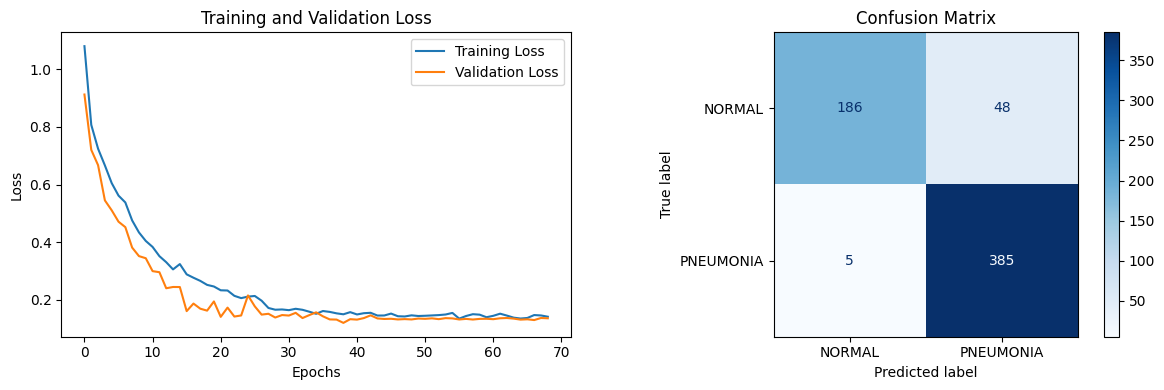

In [71]:
cnn_complex_dl_m_aug_metrics = evaluate_cnn_model(cnn_complex_dl_m_aug, X_valid_m, y_valid, X_test_m, y_test, history_cnn_complex_dl_m, graphics)
model_metrics_dict["cnn_complex_dl_m"] = cnn_complex_dl_m_aug_metrics

In [72]:
history_cnn_complex_dl_l = cnn_complex_dl_l_aug.fit(train_generator_dl_l, validation_data=(X_valid_l, y_valid), batch_size=32, epochs=1000, callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), reduce_lr])

Epoch 1/1000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6981 - loss: 1.2231 - precision: 0.7418 - recall: 0.9075 - val_accuracy: 0.7564 - val_loss: 0.8837 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7449 - loss: 0.8586 - precision: 0.7454 - recall: 0.9990 - val_accuracy: 0.7564 - val_loss: 0.6975 - val_precision: 0.7564 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7434 - loss: 0.6986 - precision: 0.7467 - recall: 0.9865 - val_accuracy: 0.8214 - val_loss: 0.4805 - val_precision: 0.9549 - val_recall: 0.8018 - learning_rate: 0.0010
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8192 - loss: 0.5168 - precision: 0.8543 - recall: 0.9081 - val_accuracy: 0.8892 - val_loss: 0.3532 - val_precision: 0.9694 - val_recall: 0.8813 - learning_rate: 0.0010
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
F1-score sul set di validazione: 0.98
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1-score sul set di test: 0.94
Precision sul set di test: 0.90
Recall sul set di test: 0.98












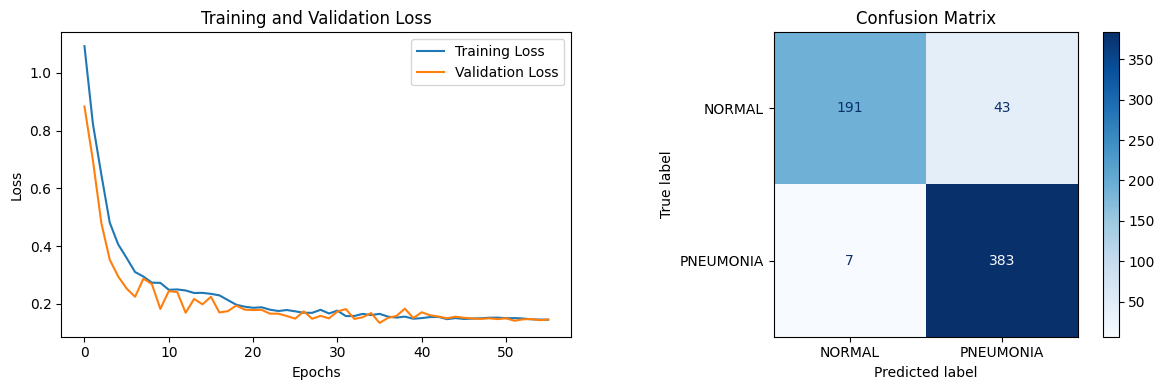

In [73]:
cnn_complex_dl_l_aug_metrics = evaluate_cnn_model(cnn_complex_dl_l_aug, X_valid_l, y_valid, X_test_l, y_test, history_cnn_complex_dl_l, graphics)
model_metrics_dict["cnn_complex_dl_l"] = cnn_complex_dl_l_aug_metrics

## Risultati
L'adozione delle tecniche di Dataset Augmentation ha migliorato la capacità di generalizzazione del modello, mostrando tuttavia che un'eccessiva variabilità nei dati può risultare controproducente.

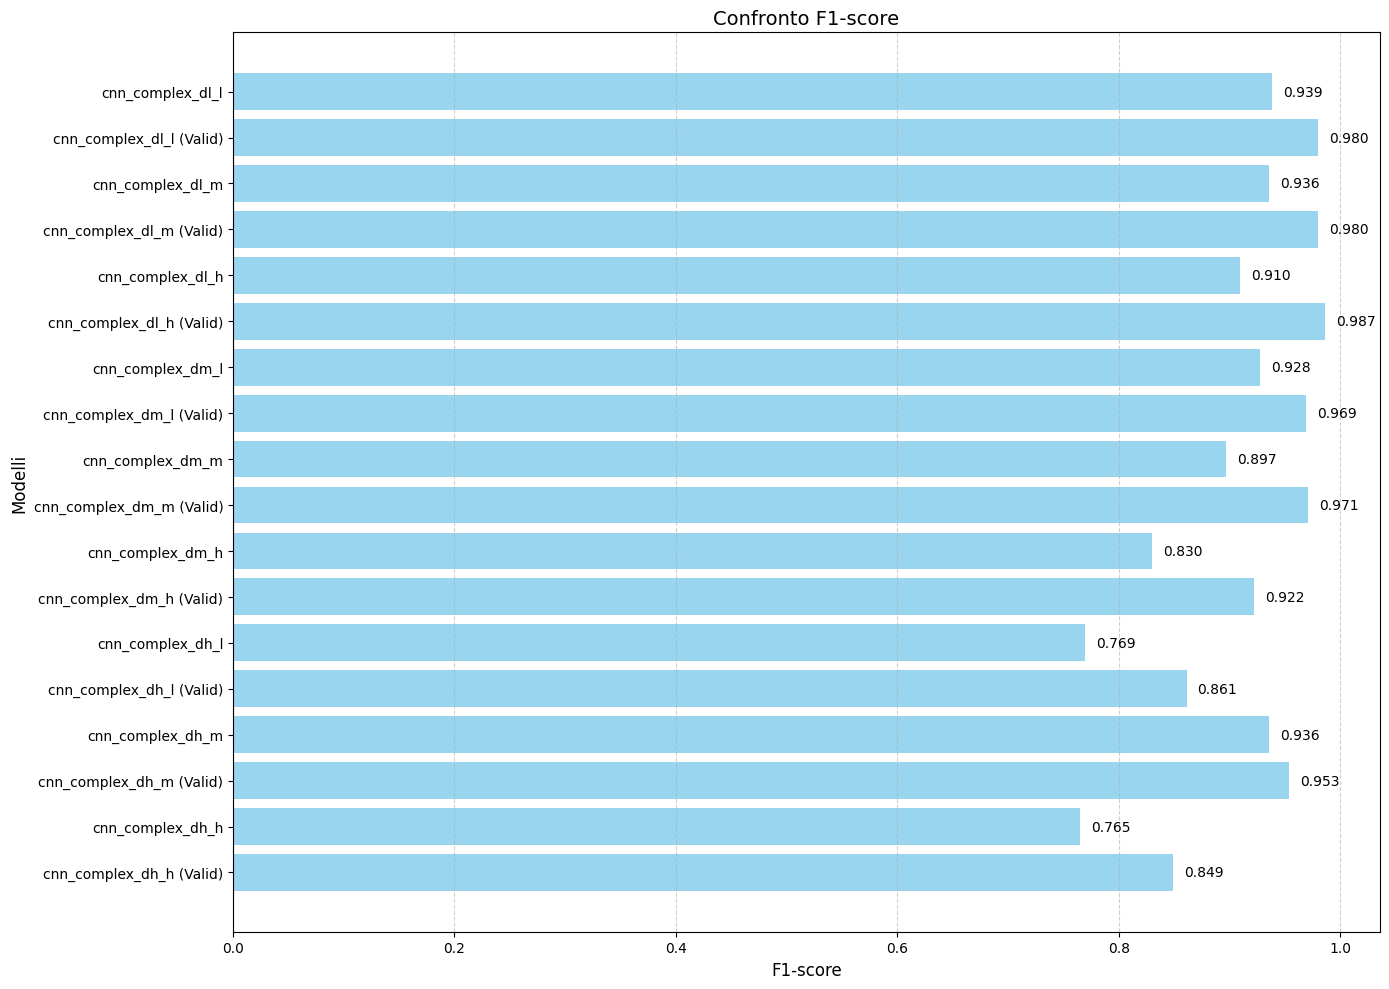

In [74]:
plot_f1_scores(model_metrics_dict, augmented=True, validation=True, rf=False, onlyAug=True)

## Sistema di Ottimizzazione Soglie con Temperatura

### Scopo del Sistema
Questo strumento permette di **modulare il comportamento** del modello di classificazione senza riaddestrarlo, agendo su due leve principali:
- **Temperatura (τ):** Regola la "confidenza" delle previsioni
- **Soglia Dinamica:** Adatta il punto decisionale in base alle esigenze


#### Come Funziona la Temperatura?
##### Effetti Principali
| Temperatura | Analogia                  | Effetto sulle Probabilità      |
|-------------|---------------------------|--------------------------------|
| **τ < 1**   | Studente preparato        | Probabilità più estreme        |
| **τ = 1**   | Baseline                  | Probabilità originali          |
| **τ > 1**   | Esperto cauto             | Probabilità più conservative   |

#### Meccanismo delle Soglie Dinamiche
*Logica di Selezione*  
- **Fase 1**: Calcolo delle probabilità calibrate sul validation set
- **Fase 2**: Ricerca della soglia ottimale considerando:
    -   Distribuzione delle probabilità
    -   Preferenza FP/FN
    -   Valore di τ

####  Casi d'Uso Reali
1. **Diagnostica Medica**
```
{'tau': 0.1, 'preference': 'fn'}  
```
Priorità: Minimizzare falsi negativi  
Effetto: Recall ↑ Precision ↓  



2. **Rilevazione Frodi**
```
{'tau': 2.0, 'preference': 'fp'}  
```
Priorità: Minimizzare falsi positivi  
Effetto: Precision ↑ Recall ↓

### Implementazione

#### Utility di conversione tra probabilità e logits

In [75]:
def inverse_sigmoid(probs, epsilon=1e-7):
    # Clip delle probabilità per evitare valori estremi
    probs = np.clip(probs, epsilon, 1 - epsilon)
    # Calcolo dei logits con formula inversa della sigmoide
    return np.log(probs / (1 - probs + epsilon))

def apply_temperature(logits, tau, clip_value=20):
    # Scaling dei logits con controllo per evitare overflow
    scaled_logits = logits / np.clip(tau, 1e-7, None)

    # Clipping per prevenire overflow numerico
    scaled_logits = np.clip(scaled_logits, -clip_value, clip_value)

    # Riconversione a probabilità con sigmoide
    return 1 / (1 + np.exp(-scaled_logits))


#### Funzione di valutazione

In [76]:
def evaluate_with_temperature(model, X_test, y_test, X_val, y_val, tau=1.0, preference='balanced'):
    val_probs = model.predict(X_val, verbose=0).ravel()
    test_probs = model.predict(X_test, verbose=0).ravel()

    # Conversione a logits e applicazione temperatura
    logits_val = inverse_sigmoid(val_probs)
    tempered_probs_val = apply_temperature(logits_val, tau)

    # Calcolo precisione, recall e soglie
    precision, recall, thresholds = precision_recall_curve(y_val, tempered_probs_val)
    precision = precision[:-1]
    recall = recall[:-1]

    # Gestione della preferenza
    if preference == 'fp':
        target_metric = precision
        min_threshold = np.percentile(tempered_probs_val, 75)
    elif preference == 'fn':
        target_metric = recall
        min_threshold = np.percentile(tempered_probs_val, 25)
    else:
        target_metric = 2 * (precision * recall) / (precision + recall + 1e-7)
        min_threshold = np.median(tempered_probs_val)

    # Filtra indici validi (no NaN e soglie nel range [0, 1])
    valid_indices = np.where(~np.isnan(target_metric) & (thresholds >= 0) & (thresholds <= 1))[0]

    if len(valid_indices) == 0:
        raise ValueError("Nessuna soglia valida trovata. Controllare il dataset o i parametri.")

    # Trova la soglia ottimale
    best_idx = valid_indices[np.argmax(target_metric[valid_indices])]
    best_threshold = np.clip(thresholds[best_idx],
                             min_threshold if preference == 'fp' else 0,
                             min_threshold if preference == 'fn' else 1)

    # Applica temperatura al test set
    logits_test = inverse_sigmoid(test_probs)
    tempered_probs_test = apply_temperature(logits_test, tau)
    y_pred = (tempered_probs_test >= best_threshold).astype(int)

    # Calcolo metriche finali
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    return {
        'threshold': best_threshold,
        'fp': fp,
        'fn': fn,
        'precision': tp / (tp + fp + 1e-7),
        'recall': tp / (tp + fn + 1e-7),
        'f1': f1_score(y_test, y_pred)
    }


#### Funzione di verifica

In [77]:
def run_test_suite(model, X_test, y_test, X_val, y_val):

    test_cases = [
        {'tau': 0.1, 'preference': 'fp'},  # Alta precisione
        {'tau': 2.0, 'preference': 'fp'},  # Bilanciamento FP
        {'tau': 0.1, 'preference': 'fn'},  # Alta recall
        {'tau': 2.0, 'preference': 'fn'}   # Bilanciamento FN
    ]

    print("=== Baseline (Soglia = 0.5) ===")
    test_probs = model.predict(X_test, verbose=0).ravel()
    y_pred = (test_probs >= 0.5).astype(int)

    # Calcolo metriche baseline
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    baseline = {
        'threshold': 0.5,
        'fp': fp,
        'fn': fn,
        'precision': tp / (tp + fp + 1e-7),
        'recall': tp / (tp + fn + 1e-7),
        'f1': f1_score(y_test, y_pred)
    }
    print(f"Threshold: {baseline['threshold']:.4f}, FP: {baseline['fp']}, FN: {baseline['fn']}, F1: {baseline['f1']:.4f}, Precision: {baseline['precision']:.4f}, Recall: {baseline['recall']:.4f}")

    # Esegui tutti i casi di test
    for case in test_cases:
        results = evaluate_with_temperature(model, X_test, y_test, X_val, y_val, **case)
        print(f"\nτ={case['tau']}, Pref={case['preference']}:")
        print(f"Threshold: {results['threshold']:.4f}")
        print(f"F1: {baseline['f1']} → {results['f1']}")
        print(f"FP: {baseline['fp']} → {results['fp']}")
        print(f"FN: {baseline['fn']} → {results['fn']}")
        print(f"PR: {baseline['precision']} → {results['precision']}")
        print(f"RE: {baseline['recall']} → {results['recall']}")

#### Esecuzione della test suite

In [78]:
run_test_suite(cnn_complex_dl_h_aug, X_test_h, y_test, X_valid_h, y_valid)

=== Baseline (Soglia = 0.5) ===
Threshold: 0.5000, FP: 75, FN: 2, F1: 0.9097, Precision: 0.8380, Recall: 0.9949

τ=0.1, Pref=fp:
Threshold: 1.0000
F1: 0.9097303634232122 → 0.937046004842615
FP: 75 → 49
FN: 2 → 3
PR: 0.8380129587822865 → 0.8876146786955011
RE: 0.9948717946166995 → 0.9923076920532544

τ=2.0, Pref=fp:
Threshold: 0.9961
F1: 0.9097303634232122 → 0.5528756957328386
FP: 75 → 0
FN: 2 → 241
PR: 0.8380129587822865 → 0.9999999993288591
RE: 0.9948717946166995 → 0.38205128195332017

τ=0.1, Pref=fn:
Threshold: 0.0000
F1: 0.9097303634232122 → 0.7692307692307693
FP: 75 → 234
FN: 2 → 0
PR: 0.8380129587822865 → 0.6249999998998398
RE: 0.9948717946166995 → 0.9999999997435897

τ=2.0, Pref=fn:
Threshold: 0.0053
F1: 0.9097303634232122 → 0.7692307692307693
FP: 75 → 234
FN: 2 → 0
PR: 0.8380129587822865 → 0.6249999998998398
RE: 0.9948717946166995 → 0.9999999997435897


In [79]:
run_test_suite(cnn_complex_dl_l_aug, X_test_l, y_test, X_valid_l, y_valid)

=== Baseline (Soglia = 0.5) ===
Threshold: 0.5000, FP: 43, FN: 7, F1: 0.9387, Precision: 0.8991, Recall: 0.9821

τ=0.1, Pref=fp:
Threshold: 1.0000
F1: 0.9387254901960784 → 0.9522613065326633
FP: 43 → 27
FN: 7 → 11
PR: 0.8990610326528026 → 0.9334975367158872
RE: 0.982051281799474 → 0.9717948715456936

τ=2.0, Pref=fp:
Threshold: 0.9934
F1: 0.9387254901960784 → 0.5338345864661654
FP: 43 → 0
FN: 7 → 248
PR: 0.8990610326528026 → 0.9999999992957747
RE: 0.982051281799474 → 0.36410256400920443

τ=0.1, Pref=fn:
Threshold: 0.0000
F1: 0.9387254901960784 → 0.7692307692307693
FP: 43 → 234
FN: 7 → 0
PR: 0.8990610326528026 → 0.6249999998998398
RE: 0.982051281799474 → 0.9999999997435897

τ=2.0, Pref=fn:
Threshold: 0.0104
F1: 0.9387254901960784 → 0.7692307692307693
FP: 43 → 234
FN: 7 → 0
PR: 0.8990610326528026 → 0.6249999998998398
RE: 0.982051281799474 → 0.9999999997435897


In [80]:
run_test_suite(cnn_complex_dl_m_aug, X_test_m, y_test, X_valid_m, y_valid)

=== Baseline (Soglia = 0.5) ===
Threshold: 0.5000, FP: 48, FN: 5, F1: 0.9356, Precision: 0.8891, Recall: 0.9872

τ=0.1, Pref=fp:
Threshold: 1.0000
F1: 0.9356014580801945 → 0.9488139825218477
FP: 48 → 31
FN: 5 → 10
PR: 0.8891454963304514 → 0.9245742090207848
RE: 0.9871794869263641 → 0.9743589741091386

τ=2.0, Pref=fp:
Threshold: 0.9939
F1: 0.9356014580801945 → 0.6194690265486725
FP: 48 → 0
FN: 5 → 215
PR: 0.8891454963304514 → 0.9999999994285714
RE: 0.9871794869263641 → 0.4487179486028928

τ=0.1, Pref=fn:
Threshold: 0.0000
F1: 0.9356014580801945 → 0.7692307692307693
FP: 48 → 234
FN: 5 → 0
PR: 0.8891454963304514 → 0.6249999998998398
RE: 0.9871794869263641 → 0.9999999997435897

τ=2.0, Pref=fn:
Threshold: 0.0224
F1: 0.9356014580801945 → 0.7692307692307693
FP: 48 → 234
FN: 5 → 0
PR: 0.8891454963304514 → 0.6249999998998398
RE: 0.9871794869263641 → 0.9999999997435897
